In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from scipy.stats import zscore



In [7]:
df = pd.read_csv("combineddf.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12607 entries, 0 to 12606
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   truck_id                12607 non-null  int64  
 1   route_id                12607 non-null  object 
 2   departure_date          12607 non-null  object 
 3   estimated_arrival       12607 non-null  object 
 4   delay                   12607 non-null  int64  
 5   truck_age               12607 non-null  int64  
 6   load_capacity_pounds    11985 non-null  float64
 7   mileage_mpg             12607 non-null  int64  
 8   fuel_type               12205 non-null  object 
 9   driver_id               12607 non-null  object 
 10  name                    12607 non-null  object 
 11  gender                  12365 non-null  object 
 12  age                     12607 non-null  int64  
 13  experience              12607 non-null  int64  
 14  driving_style           12111 non-null

remove: load_capacity_pounds, driver_id, name, temp

Identifying and treating null values

In [8]:
null_summary = df.isnull().sum() #null values
print(null_summary[null_summary > 0])


load_capacity_pounds      622
fuel_type                 402
gender                    242
driving_style             496
city_city_id_x              4
city_date_x                 4
city_hour_x                 4
city_temp_x                 4
city_wind_speed_x           4
city_description_x          4
city_precip_x               4
city_humidity_x             4
city_visibility_x           4
city_pressure_x             4
city_chanceofrain_x         4
city_chanceoffog_x          4
city_chanceofsnow_x         4
city_chanceofthunder_x      4
no_of_vehicles              4
dtype: int64


In [9]:
columns_with_null = df.columns[df.isnull().any()]
columns_with_null

Index(['load_capacity_pounds', 'fuel_type', 'gender', 'driving_style',
       'city_city_id_x', 'city_date_x', 'city_hour_x', 'city_temp_x',
       'city_wind_speed_x', 'city_description_x', 'city_precip_x',
       'city_humidity_x', 'city_visibility_x', 'city_pressure_x',
       'city_chanceofrain_x', 'city_chanceoffog_x', 'city_chanceofsnow_x',
       'city_chanceofthunder_x', 'no_of_vehicles'],
      dtype='object')

In [10]:

def visualize_column(df, column, numerical):
    data = df[column].dropna()

    if numerical == True:
        plt.figure(figsize=(12, 16))
        
        #1. Boxplot
        plt.subplot(4, 1, 1)
        sns.boxplot(x=data)
        plt.title(f'Boxplot of {column}')
        plt.xlabel(column)
        
        #2. Histogram
        plt.subplot(4, 1, 2)
        plt.hist(data, bins=30, edgecolor='black')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        #3. KDE Plot
        plt.subplot(4, 1, 3)
        sns.kdeplot(data, shade=True)
        plt.title(f'Density Plot of {column}')
        plt.xlabel(column)
        
        #4.Scatter Plot
        plt.subplot(4, 1, 4)
        plt.scatter(range(len(data)), data, alpha=0.6)
        plt.title(f'Scatter Plot of {column}')
        plt.xlabel('Index')
        plt.ylabel(column)
        
        plt.tight_layout()
        plt.show()
        
        # Print Summary Statistics
        print(f"Summary Statistics for {column}:")
        print(data.describe(), "\n")
        
        # Outliers
        z_scores = zscore(data)
        outliers = data[(z_scores > 3) | (z_scores < -3)]
        if len(outliers) > 0:
            print(f"Outliers in {column} (Z-Score > 3):")
            print(outliers)
        else:
            print(f"No significant outliers detected in {column}.")
    
    else:
        #Bar chart for categorical data
        plt.figure(figsize=(4, 4))
        data.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'Bar Chart of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()
        
        #Counts for each category
        print(f"Value Counts for {column}:")
        print(data.value_counts(), "\n")


In [11]:
def replace_outliers(df, column,replace_value,skewed):
    if skewed == False:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        outliers = df[(df[column]< lower_bound) | (df[column] > upper_bound)].index
        df[column].iloc[outliers] = replace_value

    else:
        z_scores = zscore(df[column].dropna())  # dropna to avoid NaN values in Z-score calculation 
        outliers = np.where(np.abs(z_scores) > 3)[0]
        df[column].iloc[outliers] = replace_value
    print(f"Replaced outliers {column}.")

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


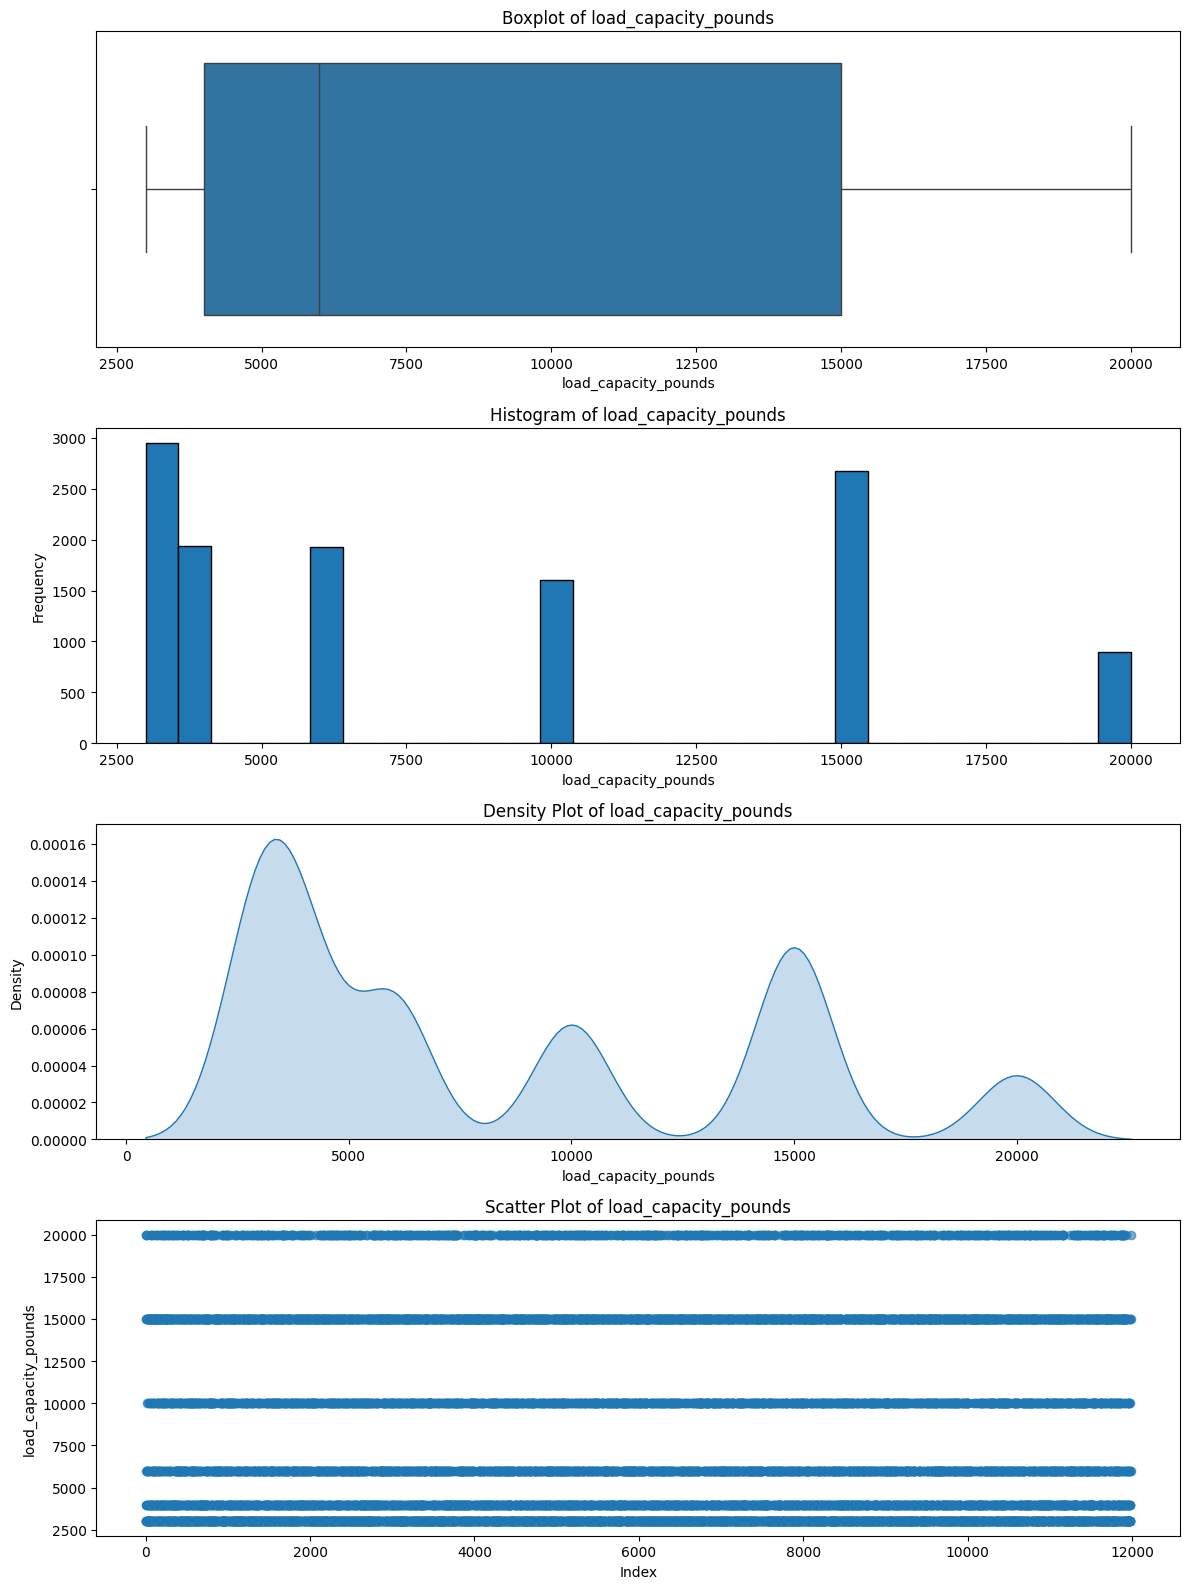

Summary Statistics for load_capacity_pounds:
count    11985.000000
mean      8523.153942
std       5596.225727
min       3000.000000
25%       4000.000000
50%       6000.000000
75%      15000.000000
max      20000.000000
Name: load_capacity_pounds, dtype: float64 

No significant outliers detected in load_capacity_pounds.


In [12]:
visualize_column(df, columns_with_null[0],True)

load_capacity_pounds-> use KNN

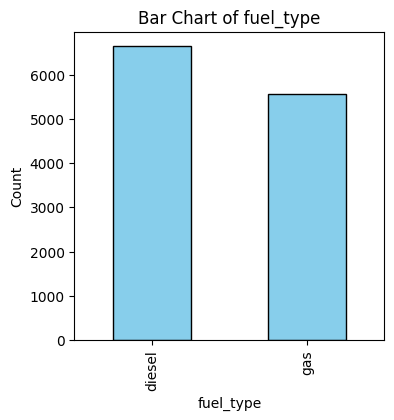

Value Counts for fuel_type:
fuel_type
diesel    6642
gas       5563
Name: count, dtype: int64 



In [13]:
visualize_column(df, columns_with_null[1],False)


fuel_type-> forward fill

In [14]:
print(df['fuel_type'].head(20))

0     diesel
1     diesel
2     diesel
3     diesel
4     diesel
5     diesel
6        NaN
7        gas
8     diesel
9        gas
10    diesel
11       gas
12    diesel
13    diesel
14       gas
15    diesel
16       gas
17    diesel
18    diesel
19    diesel
Name: fuel_type, dtype: object


In [15]:
df['fuel_type'] = df['fuel_type'].fillna(method='ffill')

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\401870940.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['fuel_type'] = df['fuel_type'].fillna(method='ffill')


In [16]:
df['fuel_type'].isnull().sum() 

0

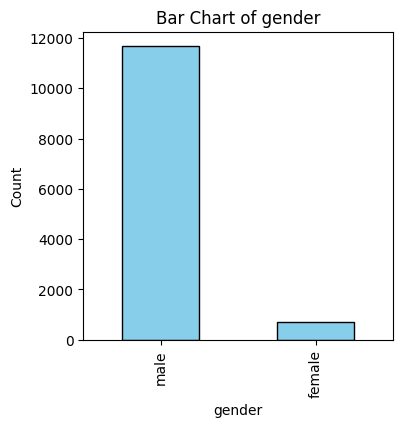

Value Counts for gender:
gender
male      11663
female      702
Name: count, dtype: int64 



In [17]:
visualize_column(df, columns_with_null[2],False) 


gender-> mode

In [18]:
df['gender'] = df['gender'].fillna('male')
df['gender'].isnull().sum()

0

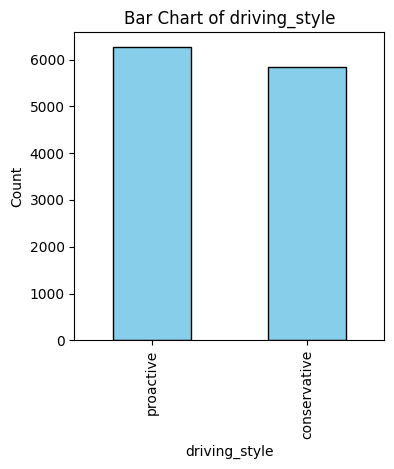

Value Counts for driving_style:
driving_style
proactive       6269
conservative    5842
Name: count, dtype: int64 



In [19]:
visualize_column(df,columns_with_null[3],False) 

Driving_style-> forward fill

In [20]:
df['driving_style'] = df['driving_style'].fillna(method='ffill')
df['driving_style'].isnull().sum()

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\752755801.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['driving_style'] = df['driving_style'].fillna(method='ffill')


0

In [21]:
df[columns_with_null[4]].head(20)

0     C-927ceb5e
1     C-a9f2c329
2     C-c7cacd1d
3     C-c7cacd1d
4     C-c7cacd1d
5     C-c7cacd1d
6     C-ef47bdcd
7     C-a9f2c329
8     C-ef47bdcd
9     C-ef47bdcd
10    C-ef47bdcd
11    C-84f378bb
12    C-84f378bb
13    C-84f378bb
14    C-84f378bb
15    C-ef47bdcd
16    C-c4565ee8
17    C-a9f2c329
18    C-639c5e36
19    C-d80a1e7d
Name: city_city_id_x, dtype: object

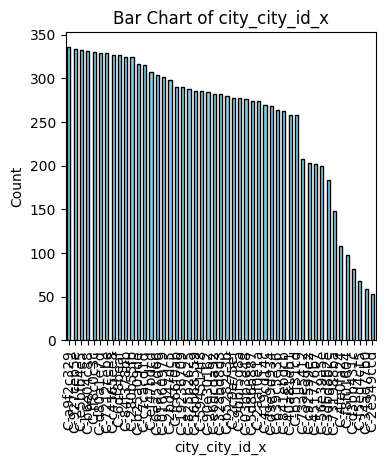

Value Counts for city_city_id_x:
city_city_id_x
C-a9f2c329    336
C-927ceb5e    334
C-e5bfb4e5    332
C-b6e04c88    331
C-ff8c0c3c    330
C-d80a1e7d    329
C-7212cebe    329
C-c4565ee8    327
C-6df8beaf    327
C-84f378bb    324
C-280b55fb    324
C-b25a09de    316
C-c7cacd1d    315
C-ef47bdcd    307
C-6ea51d66    304
C-01660979    302
C-2bd47dc5    298
C-fc66f0ab    290
C-19236709    290
C-825b2625    288
C-56b68559    286
C-594514f8    285
C-90e30162    284
C-e6dcda92    282
C-328bd8d3    282
C-b5282c3b    280
C-2c9e75ef    278
C-9bbf5d8a    278
C-03bb3e48    276
C-5d86b887    274
C-2aaf0e1a    274
C-419cd14c    269
C-d9e9d934    268
C-639c5e36    264
C-841ebdcb    263
C-40a81eb1    258
C-b5ff31cd    258
C-73ae5412    207
C-c92599e2    203
C-451776b7    202
C-56e39a5e    200
C-3dbd8b2e    184
C-731988ba    148
C-4fe0fa24    108
C-f8f01604     98
C-d3bb431c     81
C-f5ed4c15     68
C-34ae77b0     59
C-2e349ccd     53
Name: count, dtype: int64 



In [22]:
visualize_column(df,columns_with_null[4],False) 

city_city_id_x-> forward fill

In [23]:
df['city_city_id_x'] = df['city_city_id_x'].fillna(method='ffill')
df['city_city_id_x'].isnull().sum()

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\2185372727.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['city_city_id_x'] = df['city_city_id_x'].fillna(method='ffill')


0

In [24]:
df[columns_with_null[5]].head(20)

0     2019-01-01
1     2019-01-01
2     2019-01-01
3     2019-01-01
4     2019-01-01
5     2019-01-01
6     2019-01-01
7     2019-01-01
8     2019-01-01
9     2019-01-01
10    2019-01-01
11    2019-01-01
12    2019-01-01
13    2019-01-01
14    2019-01-01
15    2019-01-01
16    2019-01-01
17    2019-01-01
18    2019-01-01
19    2019-01-01
Name: city_date_x, dtype: object

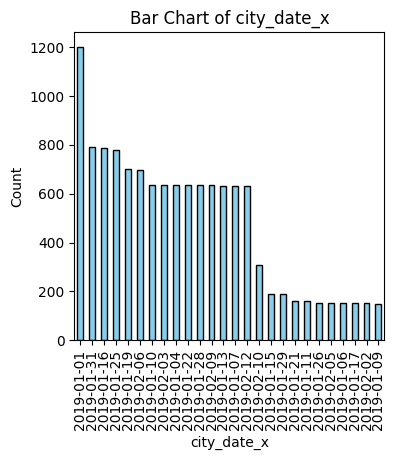

Value Counts for city_date_x:
city_date_x
2019-01-01    1201
2019-01-31     793
2019-01-16     789
2019-01-25     778
2019-01-19     703
2019-02-06     698
2019-01-10     637
2019-02-03     636
2019-01-04     636
2019-01-22     636
2019-01-28     635
2019-02-09     635
2019-01-13     633
2019-01-07     633
2019-02-12     633
2019-02-10     309
2019-01-15     191
2019-01-29     190
2019-01-21     160
2019-01-11     160
2019-01-26     154
2019-02-05     154
2019-01-06     154
2019-01-17     153
2019-02-02     153
2019-01-09     149
Name: count, dtype: int64 



In [25]:
visualize_column(df,columns_with_null[5],False) 

city_date_x-> forward fill

In [26]:
df['city_date_x'] = df['city_date_x'].fillna(method='ffill')
df['city_date_x'].isnull().sum()

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1778734362.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['city_date_x'] = df['city_date_x'].fillna(method='ffill')


0

In [27]:
df[columns_with_null[6]].head(20)

0     700.0
1     700.0
2     700.0
3     700.0
4     700.0
5     700.0
6     700.0
7     700.0
8     700.0
9     700.0
10    700.0
11    700.0
12    700.0
13    700.0
14    700.0
15    700.0
16    700.0
17    700.0
18    700.0
19    700.0
Name: city_hour_x, dtype: float64

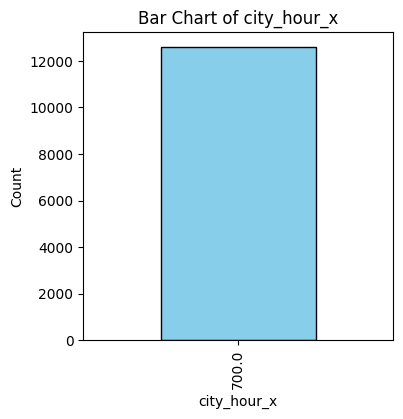

Value Counts for city_hour_x:
city_hour_x
700.0    12603
Name: count, dtype: int64 



In [28]:
visualize_column(df,columns_with_null[6],False) 

In [29]:
df['city_hour_x'] = df['city_hour_x'].fillna(700)
df['city_hour_x'].isnull().sum()

0

In [30]:
df[columns_with_null[7]].head(20)

0     27.0
1     28.0
2     37.0
3     37.0
4     37.0
5     37.0
6      0.0
7     28.0
8      0.0
9      0.0
10     0.0
11    21.0
12    21.0
13    21.0
14    21.0
15     0.0
16    41.0
17    28.0
18    -8.0
19    39.0
Name: city_temp_x, dtype: float64

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


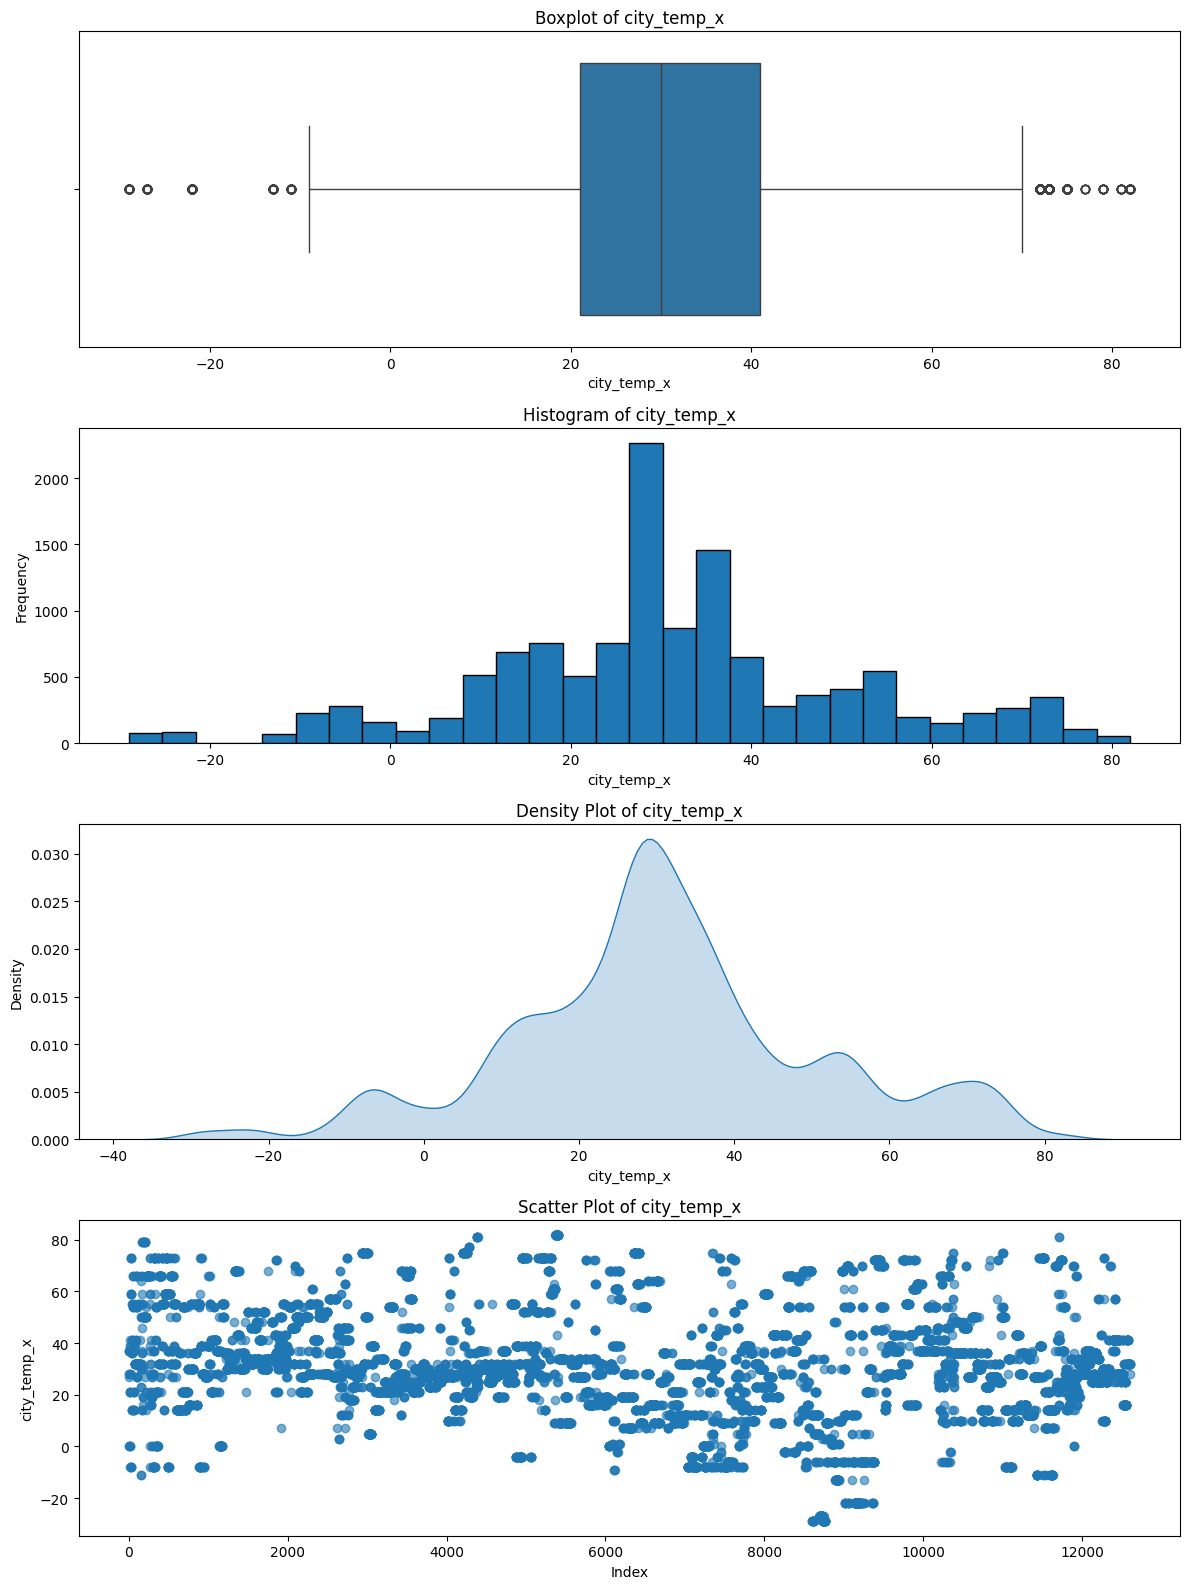

Summary Statistics for city_temp_x:
count    12603.000000
mean        30.929223
std         19.837622
min        -29.000000
25%         21.000000
50%         30.000000
75%         41.000000
max         82.000000
Name: city_temp_x, dtype: float64 

Outliers in city_temp_x (Z-Score > 3):
8608   -29.0
8609   -29.0
8610   -29.0
8611   -29.0
8612   -29.0
8613   -29.0
8614   -29.0
8621   -29.0
8633   -29.0
8634   -29.0
8635   -29.0
8737   -29.0
8738   -29.0
8739   -29.0
8740   -29.0
8741   -29.0
8742   -29.0
8743   -29.0
8744   -29.0
8745   -29.0
8746   -29.0
8747   -29.0
8748   -29.0
8749   -29.0
8751   -29.0
8752   -29.0
8754   -29.0
8755   -29.0
8759   -29.0
8760   -29.0
8761   -29.0
8762   -29.0
8763   -29.0
8764   -29.0
8765   -29.0
8766   -29.0
8767   -29.0
8768   -29.0
8769   -29.0
8770   -29.0
Name: city_temp_x, dtype: float64


In [31]:
visualize_column(df,columns_with_null[7],True) 

city_temp_x-> mean=31, outlier:normally skewed use z-score

In [32]:
replace_outliers(df,'city_temp_x', 31,False)
df['city_temp_x'] = df['city_temp_x'].fillna(31)
df['city_temp_x'].isnull().sum()

Replaced outliers city_temp_x.


C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[column].iloc[outliers] = replace_value
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:9: SettingWithCopyWarn

0

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


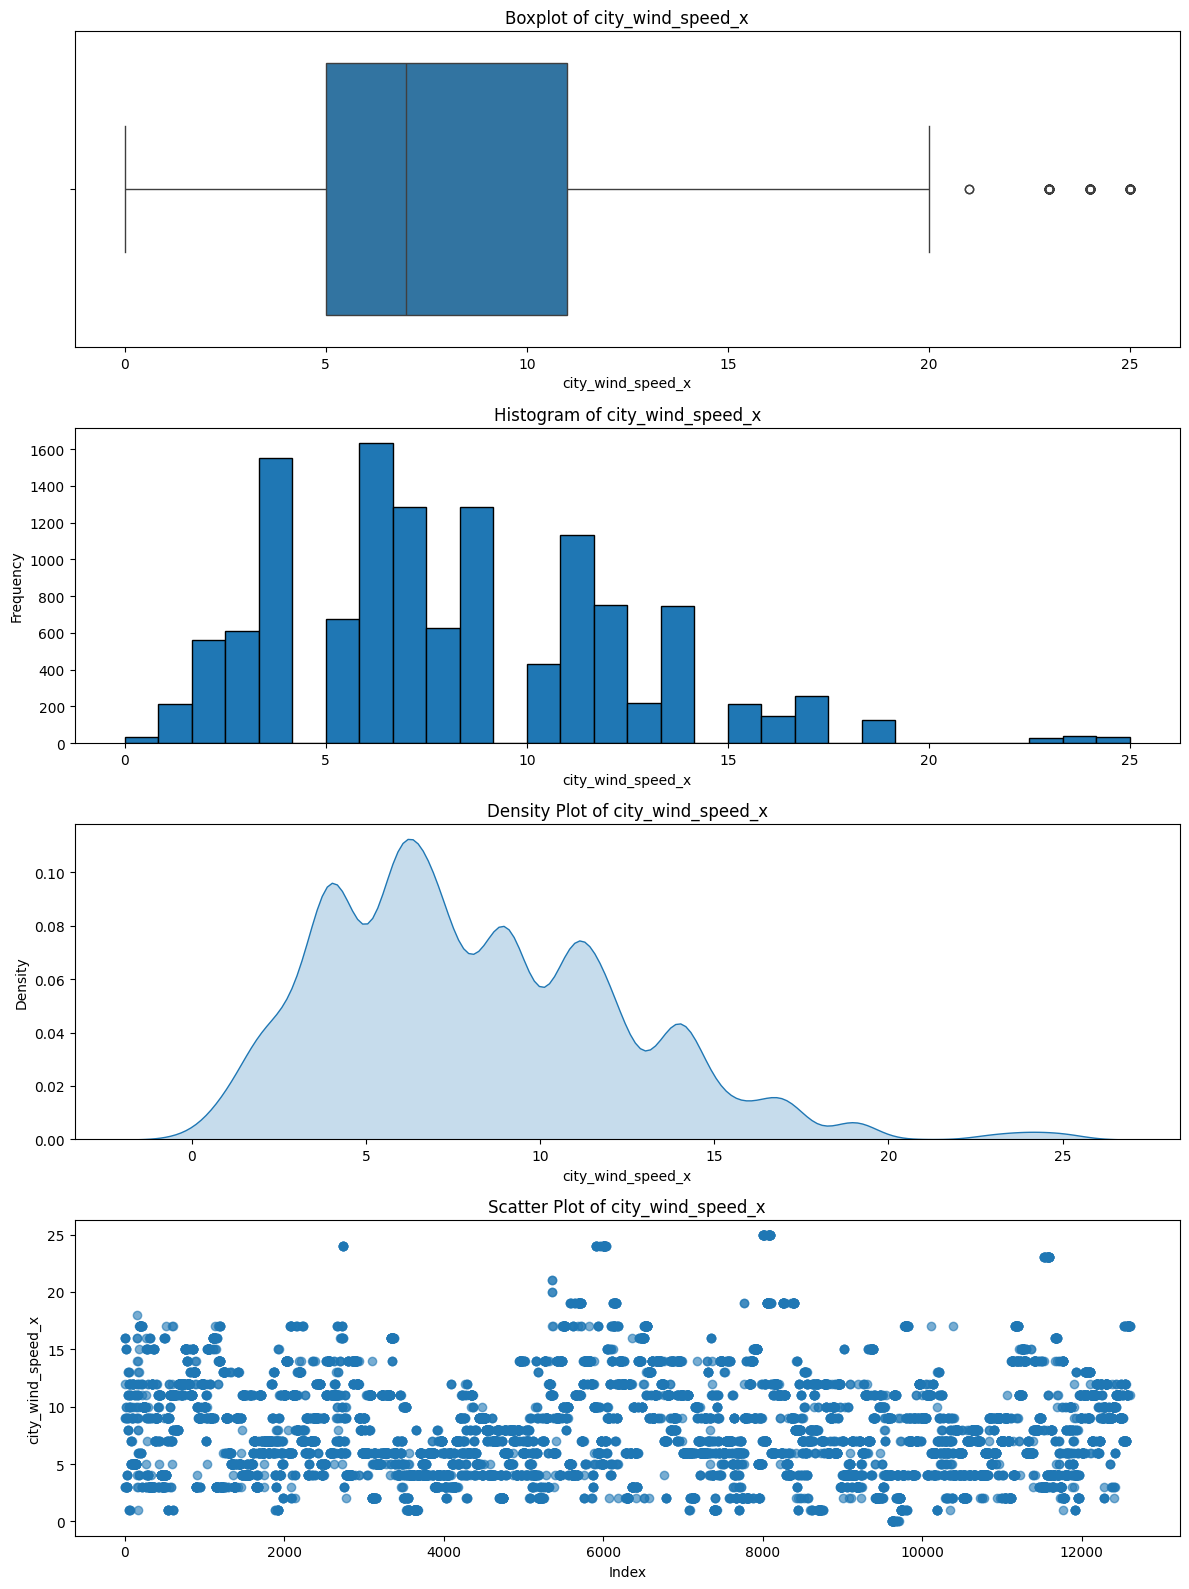

Summary Statistics for city_wind_speed_x:
count    12603.000000
mean         8.105768
std          4.248939
min          0.000000
25%          5.000000
50%          7.000000
75%         11.000000
max         25.000000
Name: city_wind_speed_x, dtype: float64 

Outliers in city_wind_speed_x (Z-Score > 3):
2737     24.0
2738     24.0
2739     24.0
2740     24.0
2741     24.0
         ... 
11592    23.0
11593    23.0
11594    23.0
11595    23.0
11596    23.0
Name: city_wind_speed_x, Length: 104, dtype: float64


In [33]:
visualize_column(df,columns_with_null[8],True) 

city_wind_speed_x-> null: KNN, outliers: iqr method bc data is skewed

In [34]:
replace_outliers(df,'city_wind_speed_x', 31,True)     #CHECK THIS!!!!!!!!!!!!!!!!!!!!!

Replaced outliers city_wind_speed_x.


C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[column].iloc[outliers] = replace_value
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:14: SettingWithCopyWa

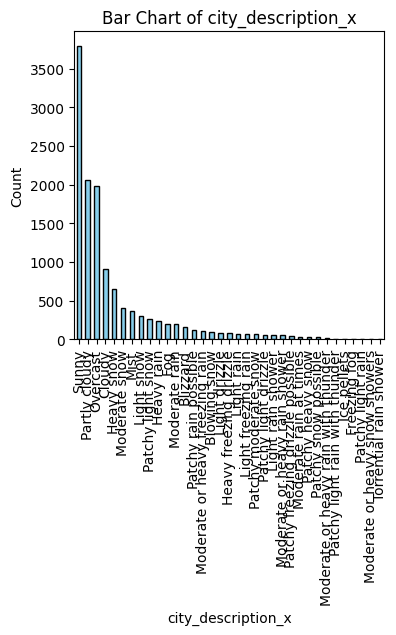

Value Counts for city_description_x:
city_description_x
Sunny                                  3792
Partly cloudy                          2063
Overcast                               1989
Cloudy                                  915
Heavy snow                              655
Moderate snow                           406
Mist                                    363
Light snow                              297
Patchy light snow                       261
Heavy rain                              242
Fog                                     201
Moderate rain                           195
Blizzard                                156
Patchy rain possible                    123
Moderate or heavy freezing rain         108
Blowing snow                            101
Light drizzle                            81
Heavy freezing drizzle                   78
Light rain                               77
Light freezing rain                      75
Patchy moderate snow                     69
Patchy light drizzle

In [35]:
visualize_column(df,columns_with_null[9],False) 

city_description_x-> mode

In [36]:
df['city_description_x'] = df['city_description_x'].fillna('Sunny')
df['city_description_x'].isnull().sum()

0

In [37]:
df[columns_with_null[10]].tail(20)

12587    0.0
12588    0.0
12589    0.0
12590    0.0
12591    0.0
12592    0.0
12593    0.0
12594    0.0
12595    0.0
12596    0.0
12597    0.0
12598    0.0
12599    0.0
12600    0.0
12601    0.0
12602    0.0
12603    0.0
12604    0.0
12605    0.0
12606    0.0
Name: city_precip_x, dtype: float64

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


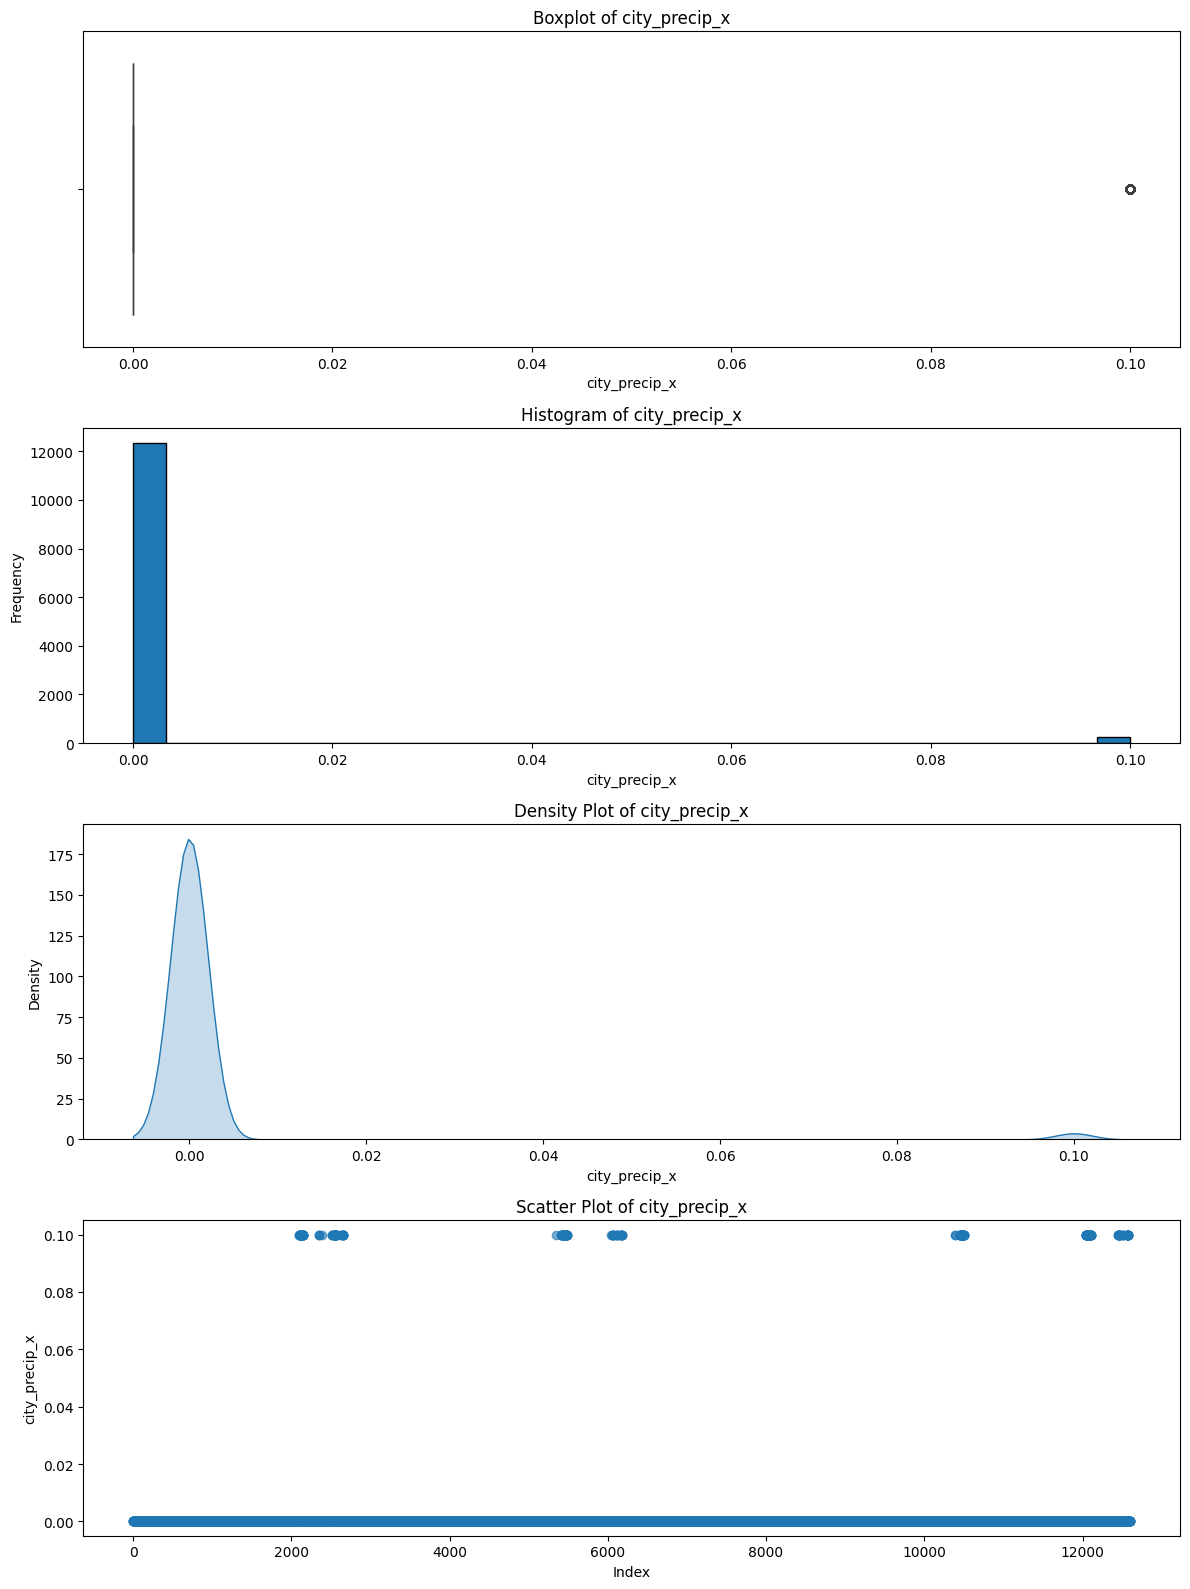

Summary Statistics for city_precip_x:
count    12603.000000
mean         0.002000
std          0.013999
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.100000
Name: city_precip_x, dtype: float64 

Outliers in city_precip_x (Z-Score > 3):
2102     0.1
2103     0.1
2104     0.1
2105     0.1
2106     0.1
        ... 
12577    0.1
12578    0.1
12579    0.1
12580    0.1
12581    0.1
Name: city_precip_x, Length: 252, dtype: float64


In [38]:
visualize_column(df,columns_with_null[10],True) 

city_precip_x-> mode

In [39]:
df['city_precip_x'] = df['city_precip_x'].fillna(0.0)
df['city_precip_x'].isnull().sum()

0

In [40]:
df[columns_with_null[11]].head(20)

0     83.0
1     84.0
2     80.0
3     80.0
4     80.0
5     80.0
6     89.0
7     84.0
8     89.0
9     89.0
10    89.0
11    58.0
12    58.0
13    58.0
14    58.0
15    89.0
16    78.0
17    84.0
18    85.0
19    84.0
Name: city_humidity_x, dtype: float64

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


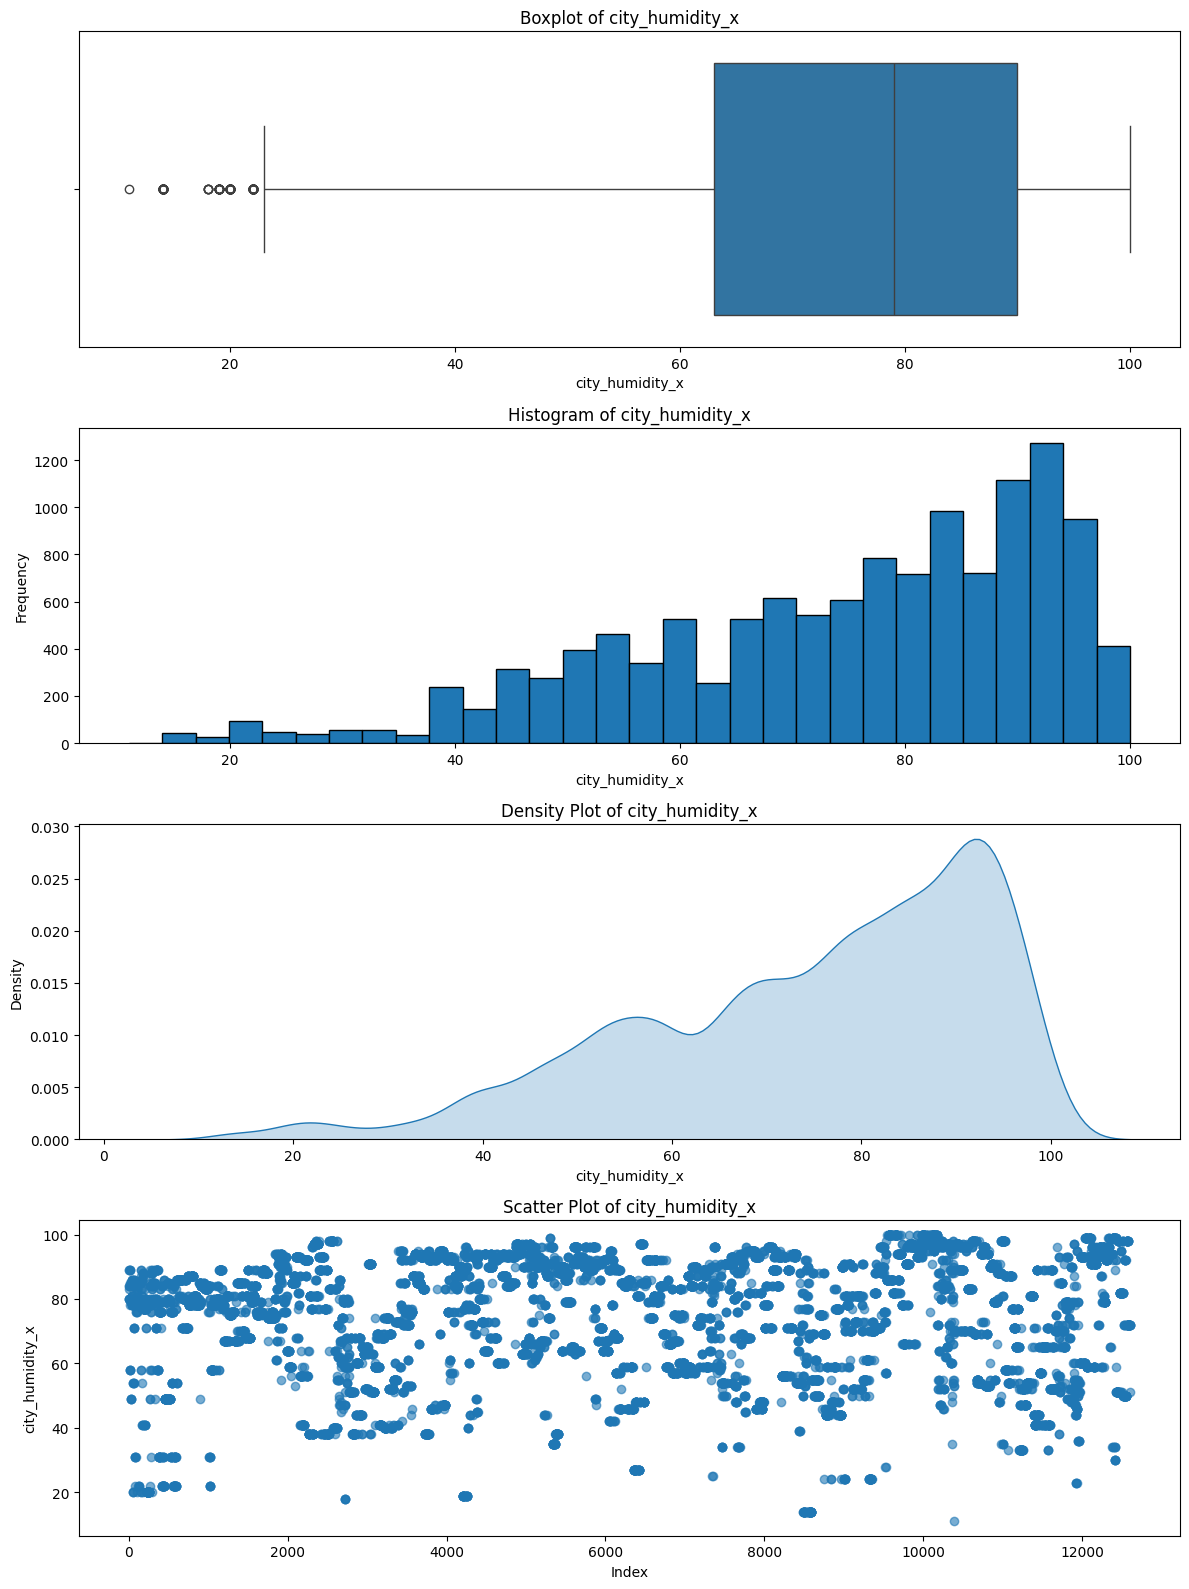

Summary Statistics for city_humidity_x:
count    12603.000000
mean        74.767992
std         18.392931
min         11.000000
25%         63.000000
50%         79.000000
75%         90.000000
max        100.000000
Name: city_humidity_x, dtype: float64 

Outliers in city_humidity_x (Z-Score > 3):
2723     18.0
2724     18.0
2725     18.0
2726     18.0
4203     19.0
         ... 
8592     14.0
8593     14.0
8594     14.0
8595     14.0
10394    11.0
Name: city_humidity_x, Length: 73, dtype: float64


In [41]:
visualize_column(df,columns_with_null[11],True) 

city_humidity_x-> null: KNN, outliers:skewed method

In [42]:
replace_outliers(df,'city_humidity_x',75 ,False)

Replaced outliers city_humidity_x.


C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[column].iloc[outliers] = replace_value
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:9: SettingWithCopyWarn

In [43]:
df[columns_with_null[12]].head(5)

0    4.0
1    3.0
2    2.0
3    2.0
4    2.0
Name: city_visibility_x, dtype: float64

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


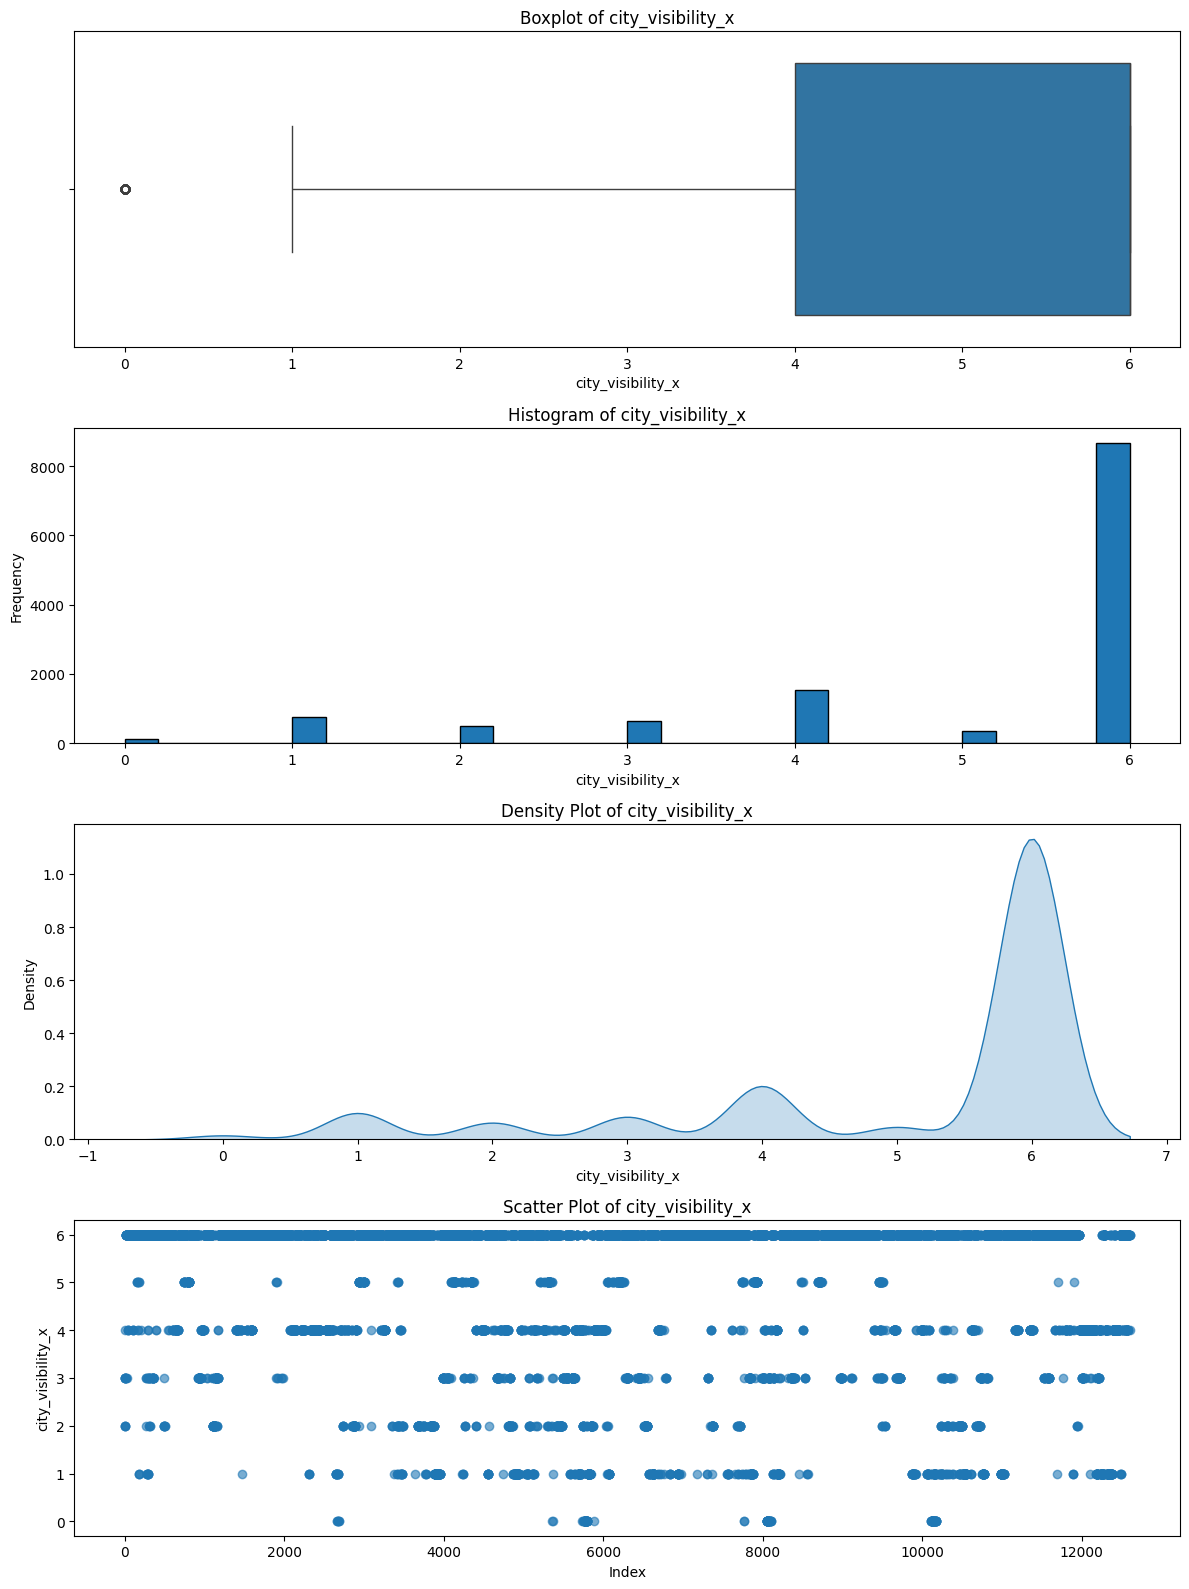

Summary Statistics for city_visibility_x:
count    12603.000000
mean         5.058478
std          1.601457
min          0.000000
25%          4.000000
50%          6.000000
75%          6.000000
max          6.000000
Name: city_visibility_x, dtype: float64 

Outliers in city_visibility_x (Z-Score > 3):
2660     0.0
2661     0.0
2680     0.0
2681     0.0
2682     0.0
        ... 
10173    0.0
10174    0.0
10175    0.0
10176    0.0
10177    0.0
Name: city_visibility_x, Length: 118, dtype: float64


In [44]:
visualize_column(df,columns_with_null[12],True) 

city_visibility_x-> null: mode, outlier: skewed

In [45]:
df['city_visibility_x'].mode()

0    6.0
Name: city_visibility_x, dtype: float64

In [46]:
df['city_visibility_x'] = df['city_visibility_x'].fillna(6)
df['city_visibility_x'].isnull().sum()

0

In [47]:
df[columns_with_null[13]].head(5)

0    1027.0
1    1026.0
2    1012.0
3    1012.0
4    1012.0
Name: city_pressure_x, dtype: float64

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


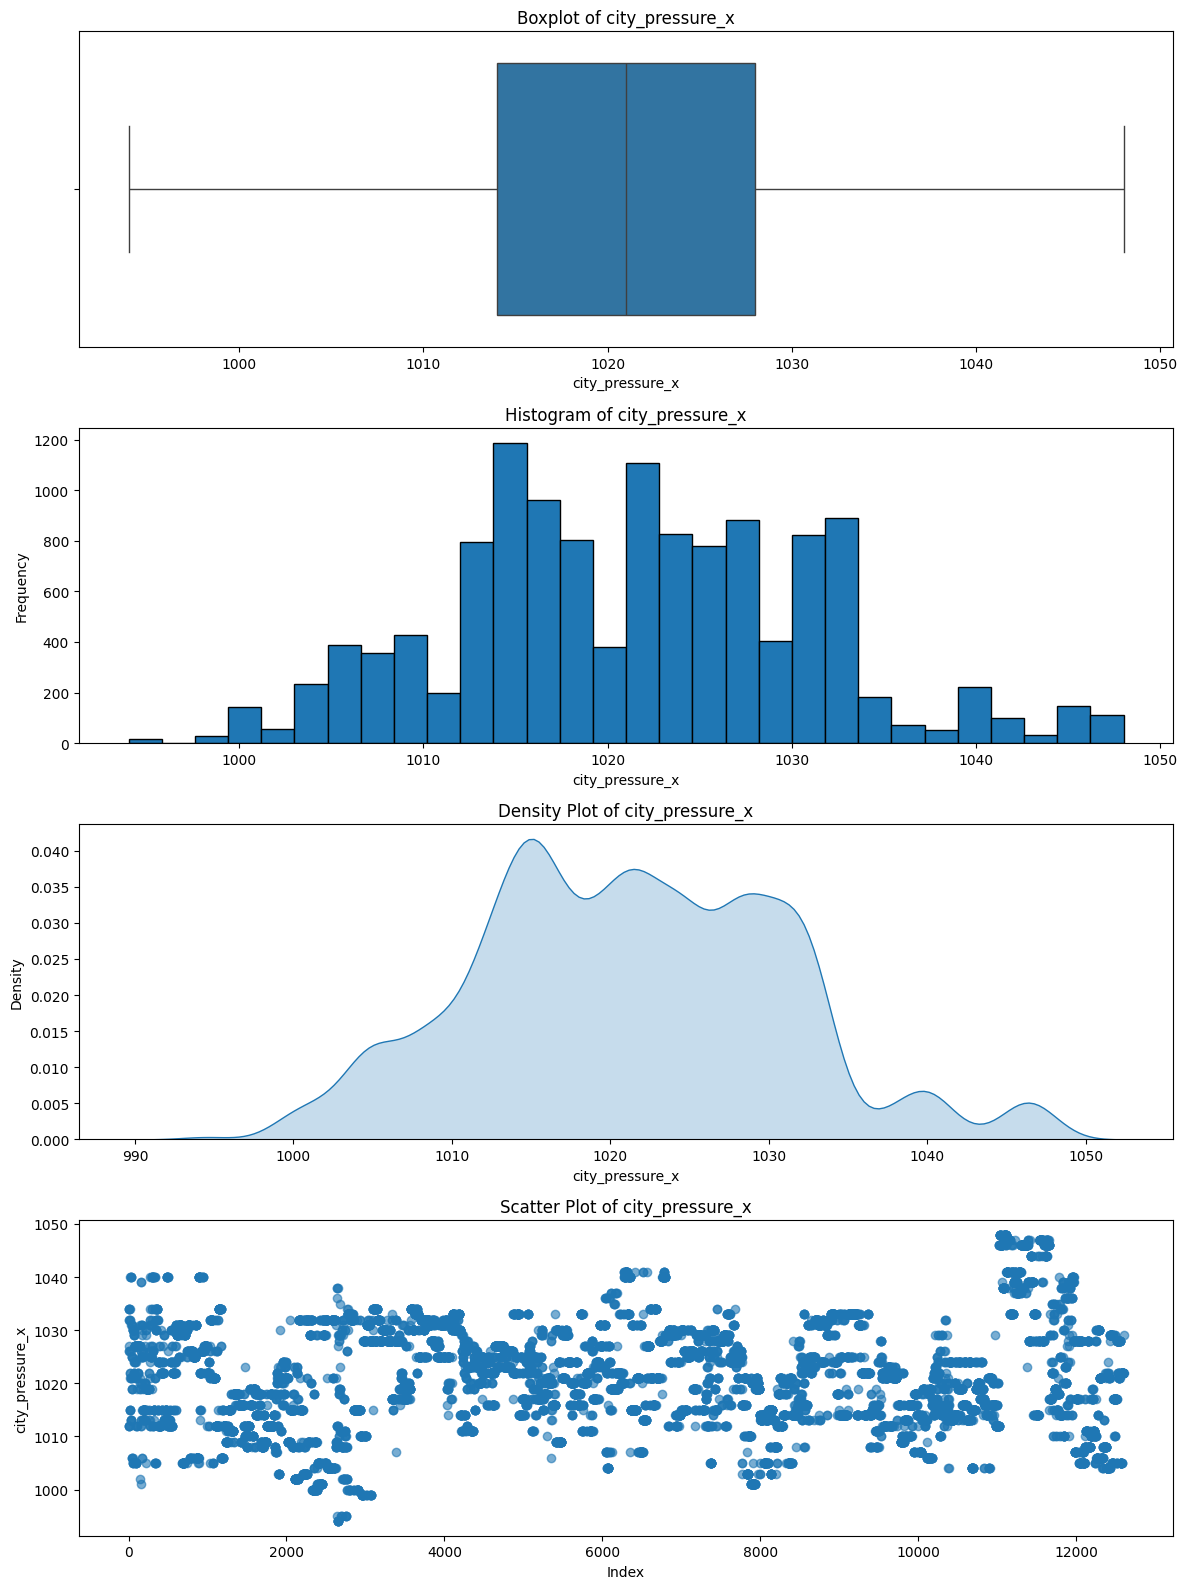

Summary Statistics for city_pressure_x:
count    12603.000000
mean      1021.239943
std          9.708996
min        994.000000
25%       1014.000000
50%       1021.000000
75%       1028.000000
max       1048.000000
Name: city_pressure_x, dtype: float64 

No significant outliers detected in city_pressure_x.


In [48]:
visualize_column(df,columns_with_null[13],True) 

city_pressure_x-> null: mean=1021.23

In [49]:
df['city_pressure_x'] = df['city_pressure_x'].fillna(1021.24)
df['city_pressure_x'].isnull().sum()

0

In [50]:
df[columns_with_null[14]].tail(5) 

12602    0.0
12603    0.0
12604    0.0
12605    0.0
12606    0.0
Name: city_chanceofrain_x, dtype: float64

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, shade=True)


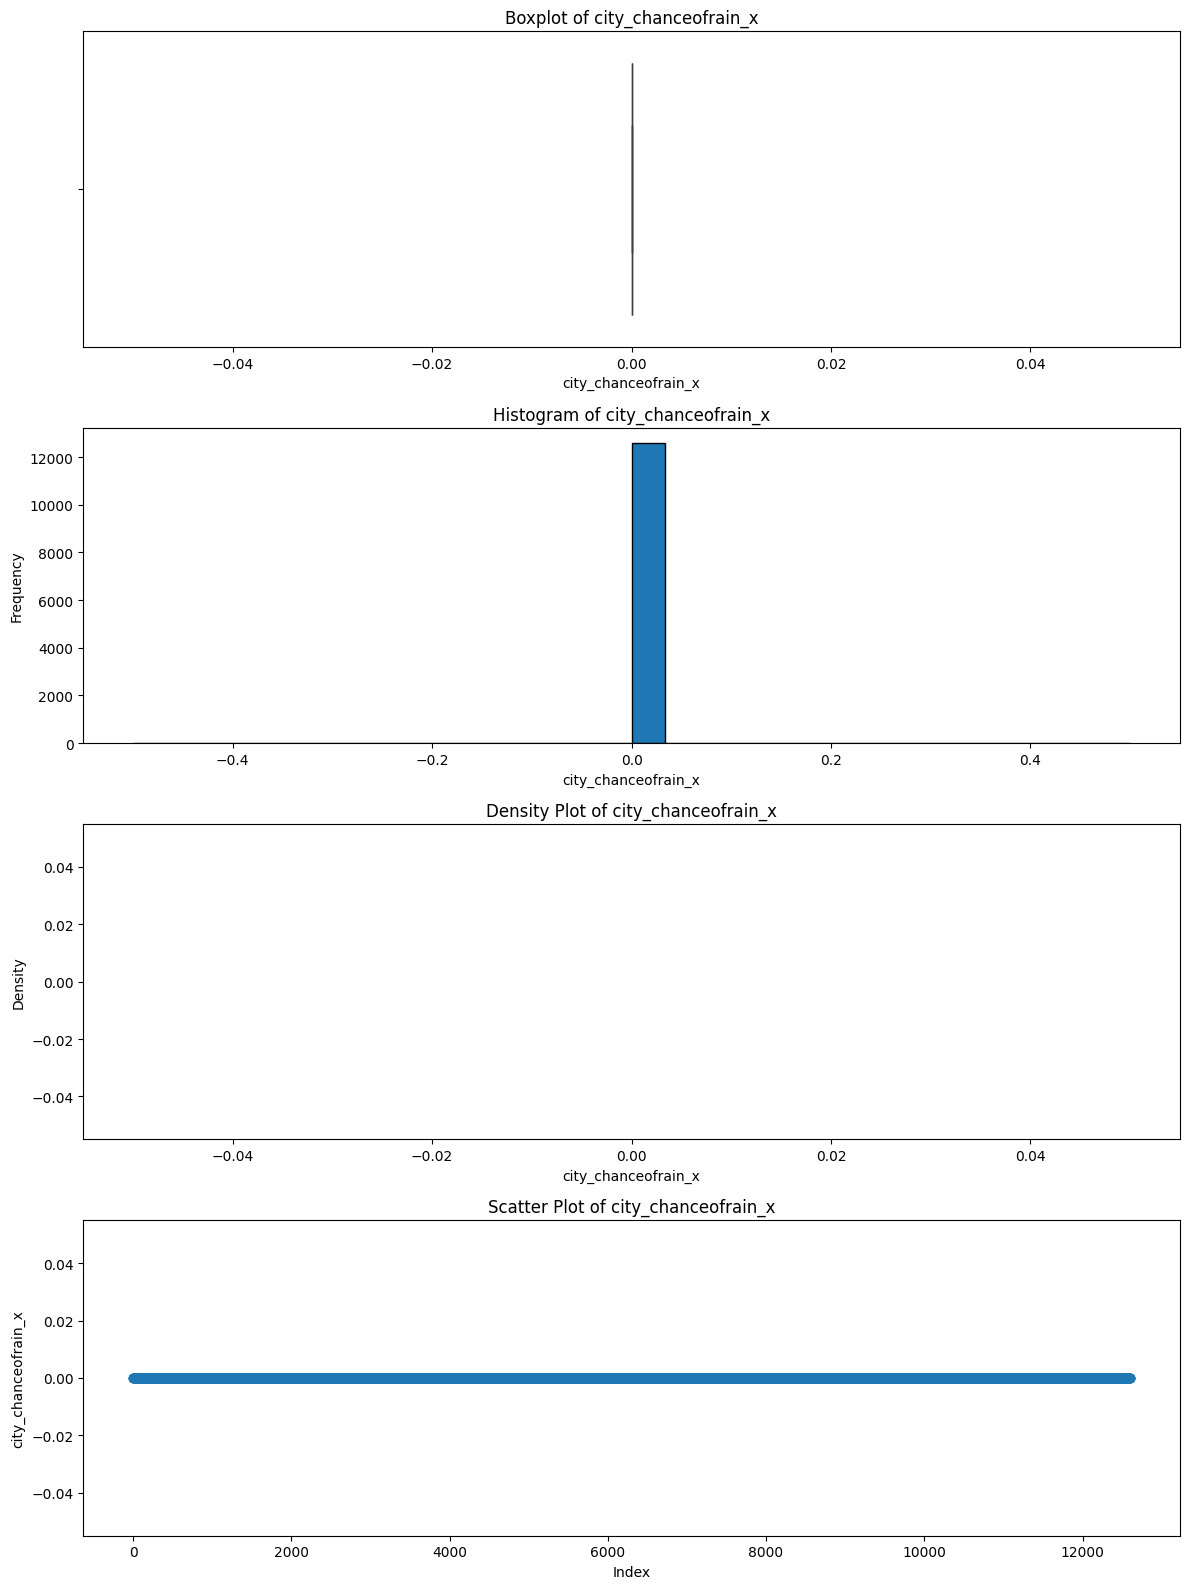

Summary Statistics for city_chanceofrain_x:
count    12603.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: city_chanceofrain_x, dtype: float64 

No significant outliers detected in city_chanceofrain_x.


In [51]:
visualize_column(df,columns_with_null[14],True) 

city_chanceofrain_x-> null: mode                 (NOT IMPORTANT )

In [52]:
df['city_chanceofrain_x'] = df['city_chanceofrain_x'].fillna(0.0)
df['city_chanceofrain_x'].isnull().sum()

0

In [53]:
df[columns_with_null[15]].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: city_chanceoffog_x, dtype: float64

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, shade=True)


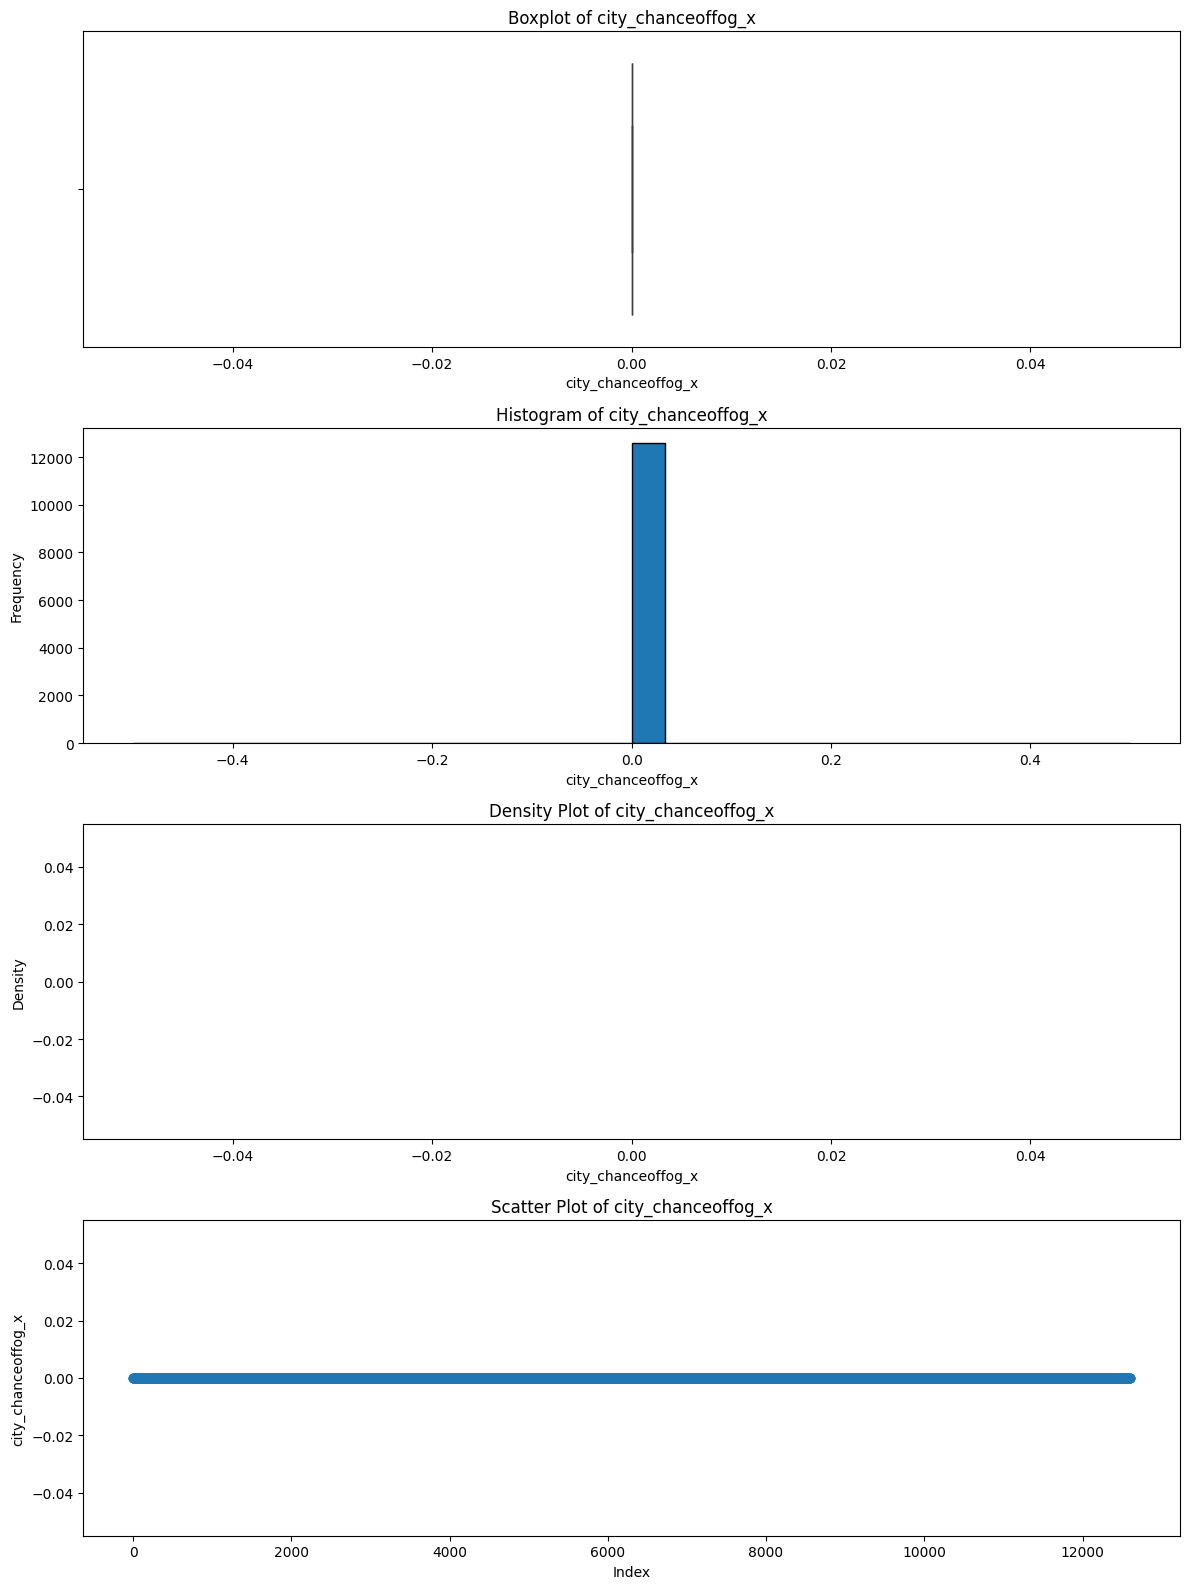

Summary Statistics for city_chanceoffog_x:
count    12603.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: city_chanceoffog_x, dtype: float64 

No significant outliers detected in city_chanceoffog_x.


In [54]:
visualize_column(df,columns_with_null[15],True) 

city_chanceoffog_x-> null: mode                 (NOT IMPORTANT )

In [55]:
df['city_chanceoffog_x'] = df['city_chanceoffog_x'].fillna(0.0)
df['city_chanceoffog_x'].isnull().sum()

0

In [56]:
df[columns_with_null[16]].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: city_chanceofsnow_x, dtype: float64

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, shade=True)


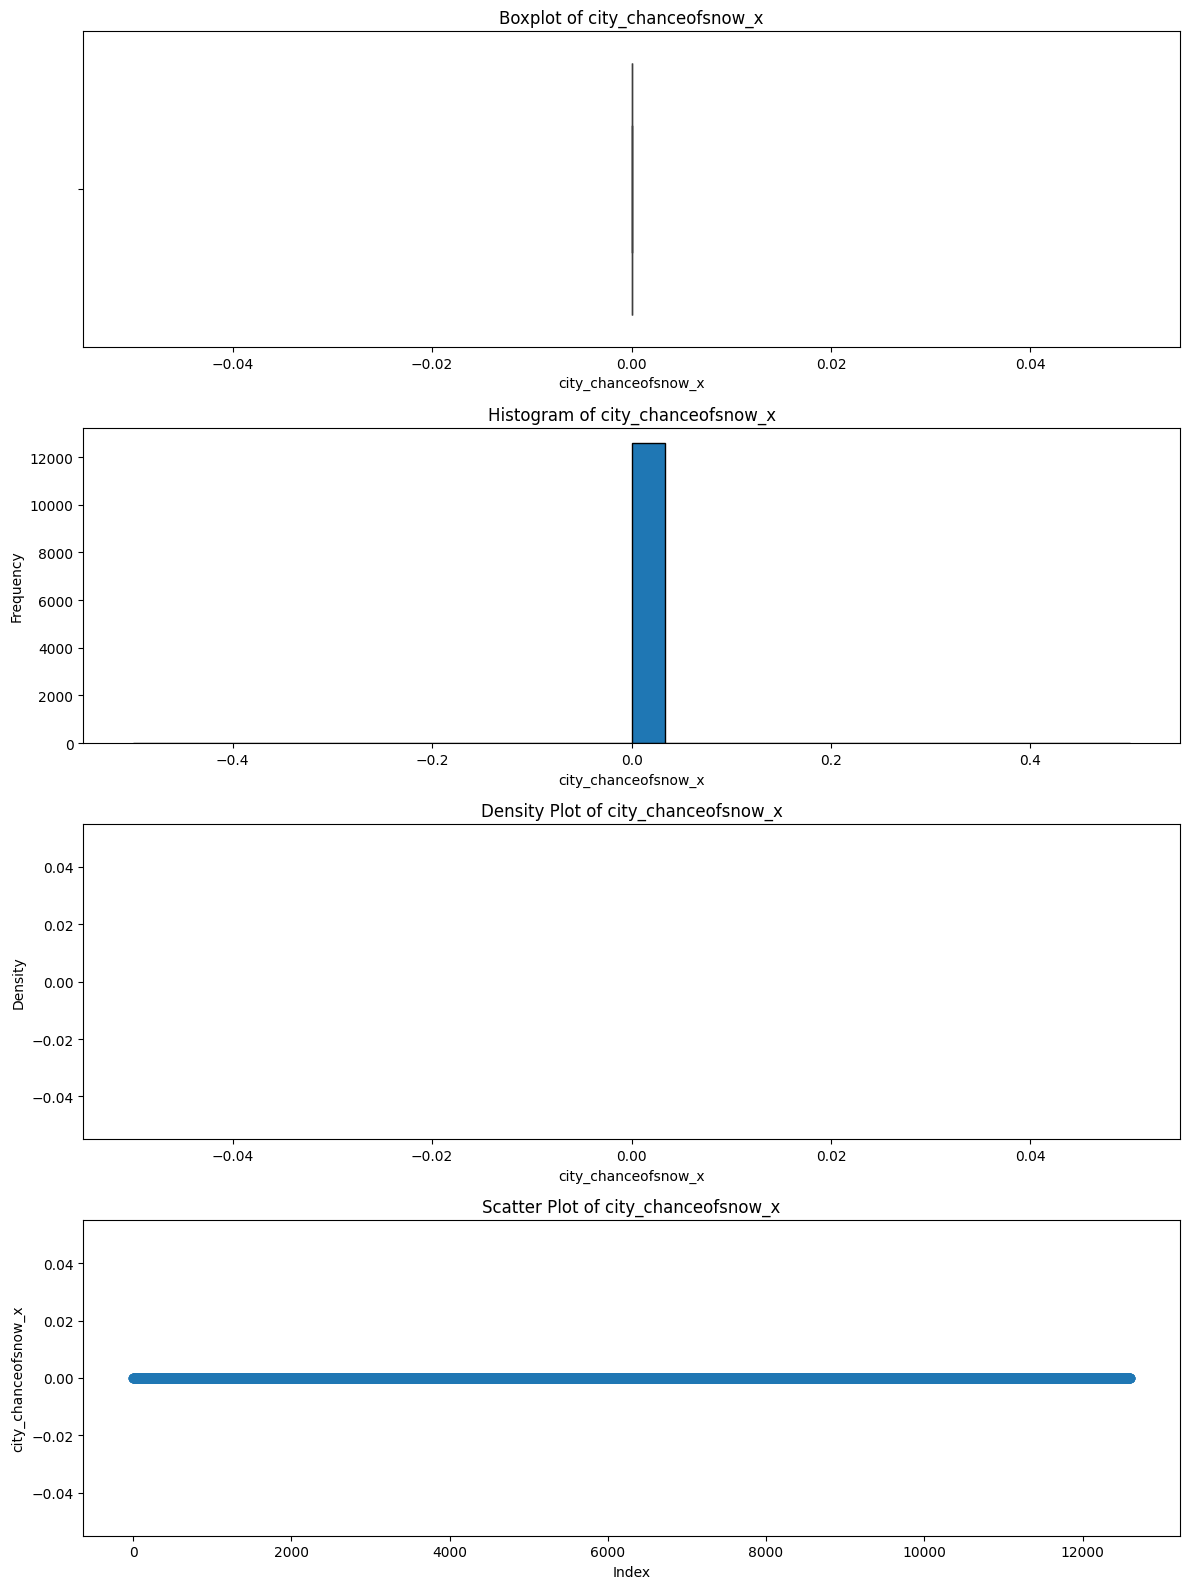

Summary Statistics for city_chanceofsnow_x:
count    12603.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: city_chanceofsnow_x, dtype: float64 

No significant outliers detected in city_chanceofsnow_x.


In [57]:
visualize_column(df,columns_with_null[16],True) 

city_chanceofsnow_x-> null: mode                 (NOT IMPORTANT )

In [58]:
df['city_chanceofsnow_x'] = df['city_chanceofsnow_x'].fillna(0.0)
df['city_chanceofsnow_x'].isnull().sum()

0

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, shade=True)


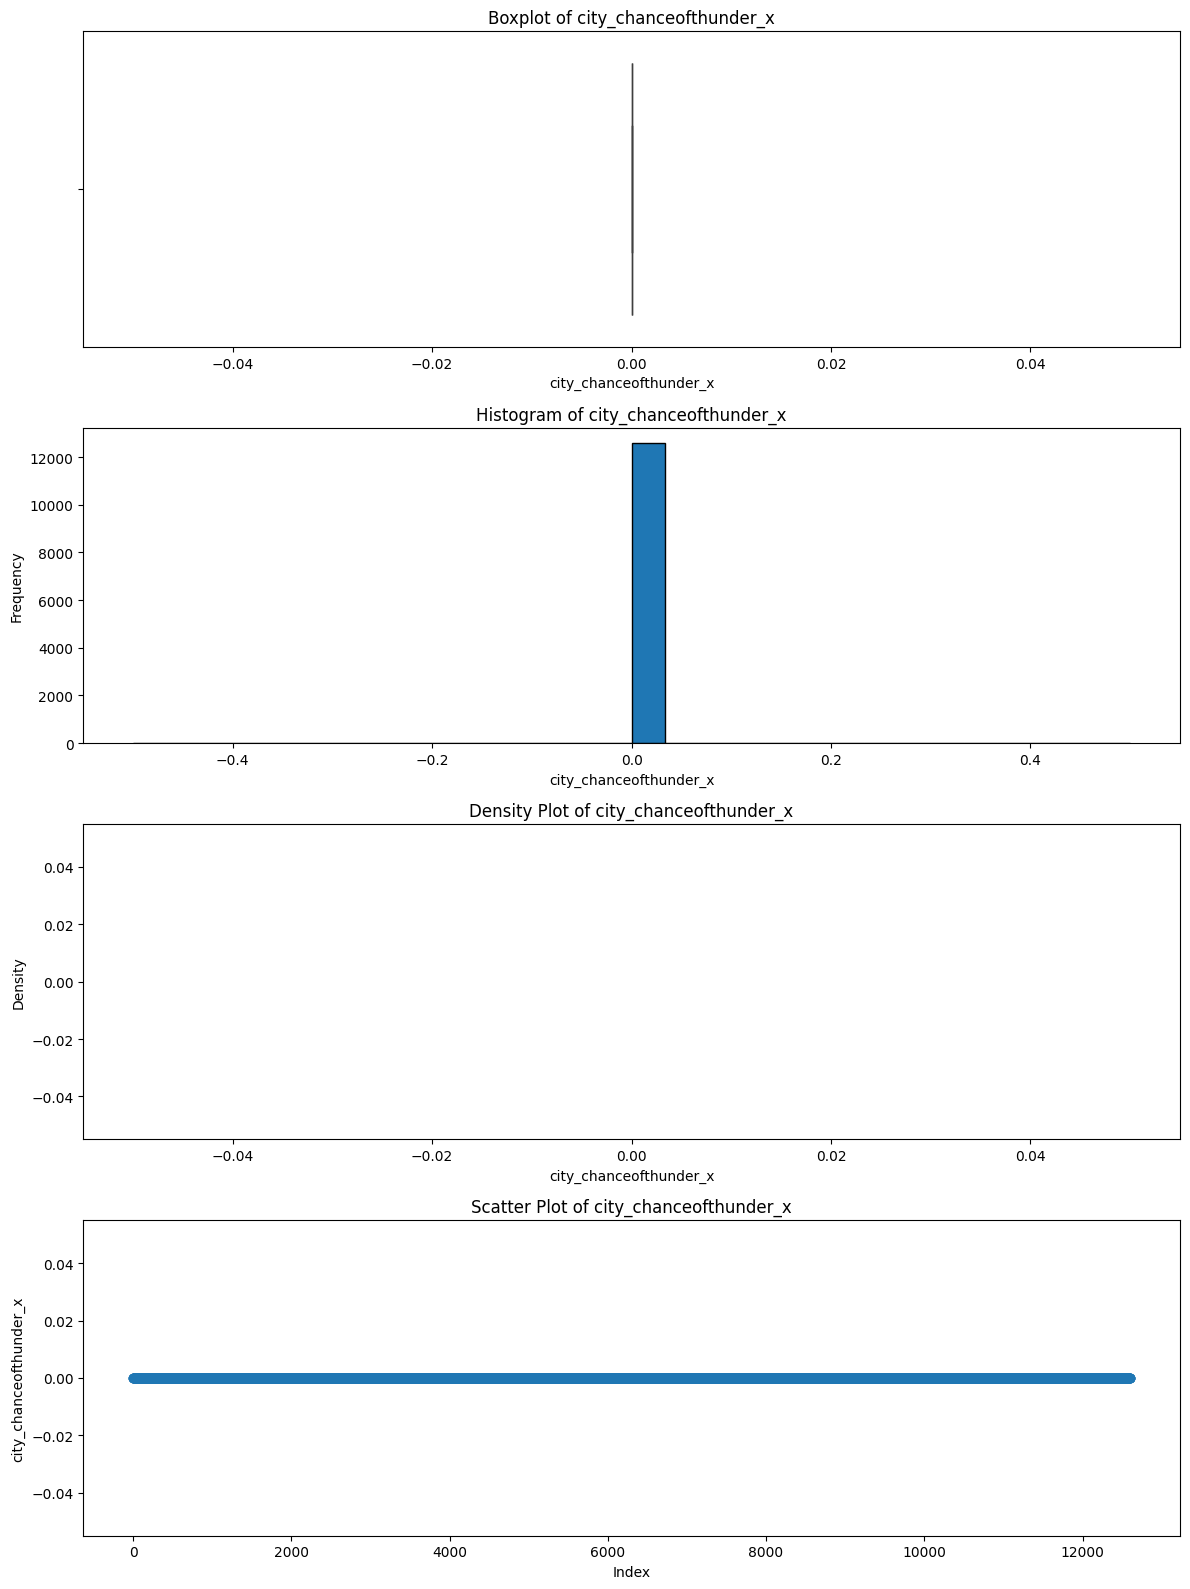

Summary Statistics for city_chanceofthunder_x:
count    12603.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: city_chanceofthunder_x, dtype: float64 

No significant outliers detected in city_chanceofthunder_x.


In [59]:
visualize_column(df,columns_with_null[17],True) 

city_chanceofthunder_x-> null: mode                 (NOT IMPORTANT )

In [60]:
df['city_chanceofthunder_x'] = df['city_chanceofthunder_x'].fillna(0.0)
df['city_chanceofthunder_x'].isnull().sum()

0

C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1311841293.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, shade=True)


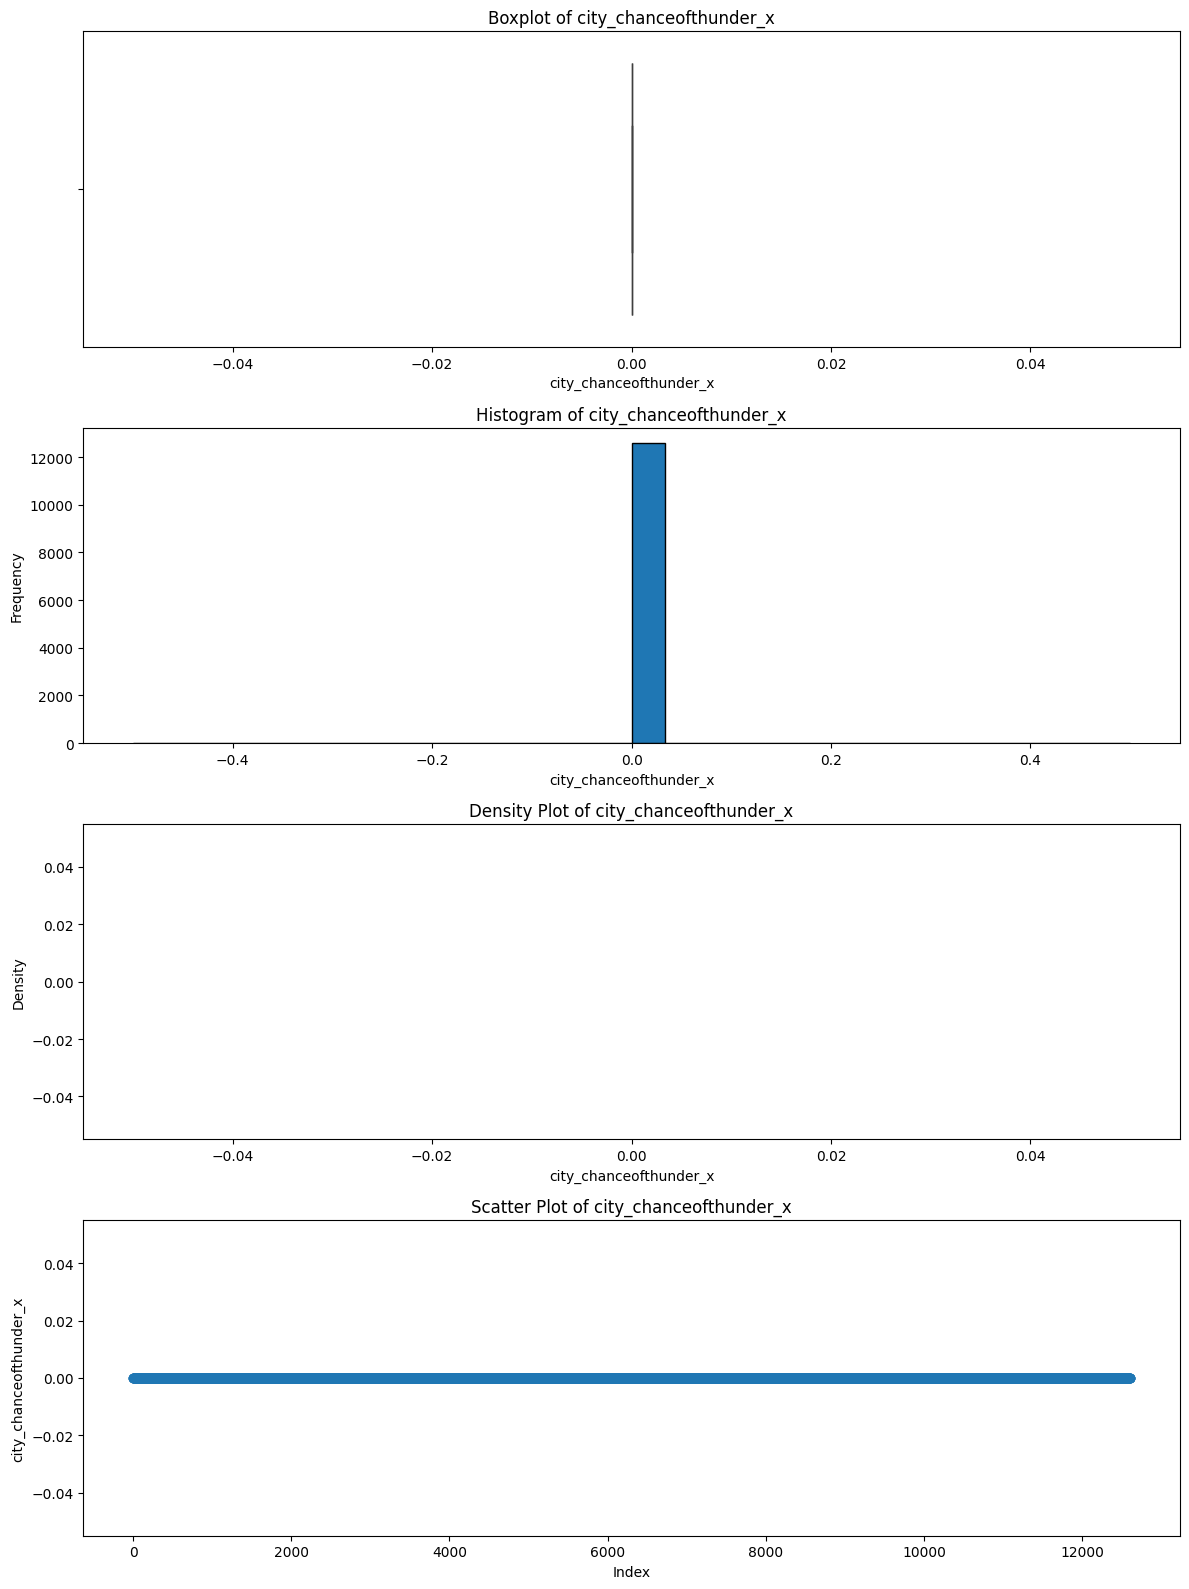

Summary Statistics for city_chanceofthunder_x:
count    12607.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: city_chanceofthunder_x, dtype: float64 

No significant outliers detected in city_chanceofthunder_x.


In [61]:
visualize_column(df,columns_with_null[17],True) 

no_of_vehicles-> null:KNN, outlier:mode=2385.0

In [62]:
df['no_of_vehicles'].mode()

0    2385.0
Name: no_of_vehicles, dtype: float64

In [63]:
replace_outliers(df,'city_humidity_x',2385.0,False)

Replaced outliers city_humidity_x.


C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[column].iloc[outliers] = replace_value
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:9: SettingWithCopyWarn

Only Columns with Outliers Treatment

In [64]:
df_filtered = df.drop(columns=columns_with_null)
df_filtered

,truck_id,route_id,departure_date,estimated_arrival,delay,truck_age,mileage_mpg,driver_id,name,age,...,city_pressure_y,city_chanceofrain_y,city_chanceoffog_y,city_chanceofsnow_y,city_chanceofthunder_y,combined_datetime_x,date,hour,accident,combined_datetime_y
0,30312694,R-b236e347,2019-01-01 07:00:00,2019-01-01 13:00:00,0,9,23,94ed3e6d-f,Manuel Wise,48,...,1025,0,0,0,0,2019-01-01 13:00:00,2019-01-01,700,0,2019-01-01 07:00:00
1,16793343,R-1a802b07,2019-01-01 07:00:00,2019-01-05 17:00:00,1,10,27,0257f2f2-c,Shannon Salinas,45,...,1018,0,0,0,0,2019-01-05 17:00:00,2019-01-01,700,0,2019-01-01 07:00:00
2,16301082,R-d377c549,2019-01-01 07:00:00,2019-01-05 23:00:00,0,11,26,b38a38cb-a,William Cooper,50,...,1018,0,0,0,0,2019-01-05 23:00:00,2019-01-01,700,0,2019-01-01 07:00:00
3,20996187,R-113cebab,2019-01-01 07:00:00,2019-01-05 23:00:00,0,8,28,ce75c223-e,Russell Velasquez,53,...,1017,0,0,0,0,2019-01-05 23:00:00,2019-01-01,700,0,2019-01-01 07:00:00
4,27204262,R-9f601372,2019-01-01 07:00:00,2019-01-06 21:00:00,0,12,23,f763b55e-0,Angel Fritz,52,...,1028,0,0,0,0,2019-01-06 21:00:00,2019-01-01,700,0,2019-01-01 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12602,16311717,R-0800a595,2019-02-12 07:00:00,2019-02-13 06:00:00,0,8,24,664895ce-d,David Yoder,44,...,1013,0,0,0,0,2019-02-13 06:00:00,2019-02-12,700,0,2019-02-12 07:00:00
12603,20724268,R-3dac8163,2019-02-12 07:00:00,2019-02-12 21:00:00,1,8,24,1fc1302f-9,Paul Thompson,45,...,1000,0,0,0,0,2019-02-12 21:00:00,2019-02-12,700,0,2019-02-12 07:00:00
12604,21928760,R-5f7269e5,2019-02-12 07:00:00,2019-02-12 15:00:00,0,13,17,87a34a65-1,Ronald Campbell,50,...,1012,0,0,0,0,2019-02-12 15:00:00,2019-02-12,700,0,2019-02-12 07:00:00
12605,29839726,R-bfbffabd,2019-02-12 07:00:00,2019-02-12 09:00:00,0,10,16,163a3367-9,Jeffrey Coleman,43,...,1025,0,0,0,0,2019-02-12 09:00:00,2019-02-12,700,0,2019-02-12 07:00:00


Categorical/other columns: route_id,departure_date,estimated_arrival,delay(predict),fuel_type, driver_id(NOT IMPORTANT), name(NOT IMPORTANT), combined_datetime_x, combined_datetime_y,	

In [65]:
columns_to_drop = ['route_id', 'departure_date', 'estimated_arrival', 'delay',
                   'fuel_type', 'driver_id', 'name', 'combined_datetime_x', 'combined_datetime_y',
                   'gender','driving_style','vehicle_no','origin_id','destination_id','date','truck_id',
                   'Date', 'chanceofthunder', 'city_city_id_x', 'city_date_x', 'city_hour_x',
                    'city_temp_x', 'city_wind_speed_x', 'city_description_x',
                    'city_precip_x', 'city_humidity_x', 'city_visibility_x',
                    'city_pressure_x', 'city_chanceofrain_x', 'city_chanceoffog_x',
                    'city_chanceofsnow_x', 'city_chanceofthunder_x', 'city_city_id_y',
                    'city_date_y', 'city_hour_y', 'city_temp_y', 'city_wind_speed_y',
                    'city_description_y', 'city_precip_y', 'city_humidity_y',
                    'city_visibility_y', 'city_pressure_y', 'city_chanceofrain_y',
                    'city_chanceoffog_y', 'city_chanceofsnow_y', 'city_chanceofthunder_y','hour','description'
]
df_filtered = df.drop(columns=columns_to_drop)
df_filtered

,truck_age,load_capacity_pounds,mileage_mpg,age,experience,ratings,average_speed_mph,distance,average_hours,temp,wind_speed,precip,humidity,visibility,pressure,chanceofrain,chanceoffog,chanceofsnow,no_of_vehicles,accident
0,9,3000.0,23,48,9,7,57.36,310.75,6.22,39,5,0.0,98,6,1008,0,0,0,1966.0,0
1,10,15000.0,27,45,8,3,60.05,5306.97,106.14,75,5,0.0,66,6,1017,0,0,0,417.0,0
2,11,20000.0,26,50,7,8,60.50,5609.50,112.19,55,4,0.0,89,6,1018,0,0,0,561.0,0
3,8,4000.0,28,53,22,9,63.94,5615.56,112.31,66,2,0.0,40,6,1019,0,0,0,561.0,0
4,12,15000.0,23,52,18,7,56.28,6705.03,134.10,63,2,0.0,83,6,1020,0,0,0,561.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12602,8,3000.0,24,44,9,3,59.04,1163.16,23.26,82,5,0.0,70,6,1018,0,0,0,1999.0,0
12603,8,15000.0,24,45,0,2,62.66,723.35,14.47,75,13,0.0,89,6,1008,0,0,0,1999.0,0
12604,13,6000.0,17,50,-7,4,35.20,420.95,8.42,72,7,0.0,91,4,1015,0,0,0,1999.0,0
12605,10,20000.0,16,43,12,6,57.07,113.10,2.26,52,2,0.0,97,0,1012,0,0,0,1999.0,0


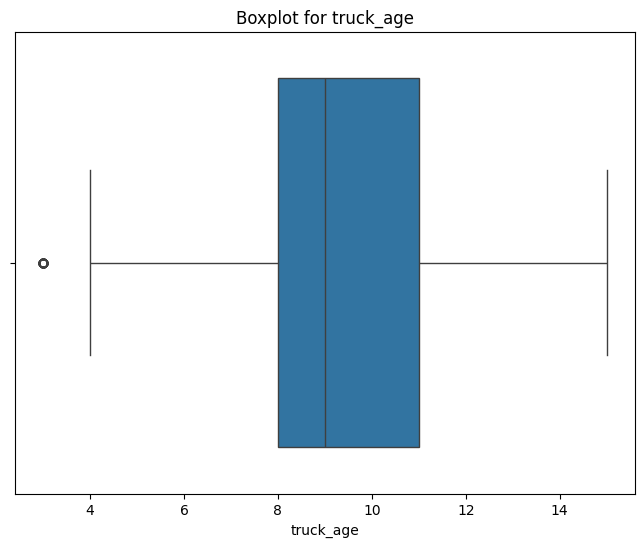

Number of outliers in 'truck_age': 60
       truck_age
706            3
935            3
1154           3
1158           3
1209           3
1395           3
1669           3
1802           3
2069           3
2403           3
2437           3
2620           3
2911           3
3068           3
3085           3
3252           3
3675           3
3745           3
3878           3
4158           3
4507           3
4837           3
4950           3
4955           3
5450           3
5758           3
5774           3
5969           3
6243           3
6282           3
6719           3
6801           3
6993           3
7023           3
7194           3
7601           3
7826           3
8323           3
8397           3
8405           3
8807           3
8946           3
9205           3
9235           3
9647           3
9705           3
9798           3
10139          3
10459          3
10832          3
10944          3
10982          3
11123          3
11332          3
11607          3
11611     

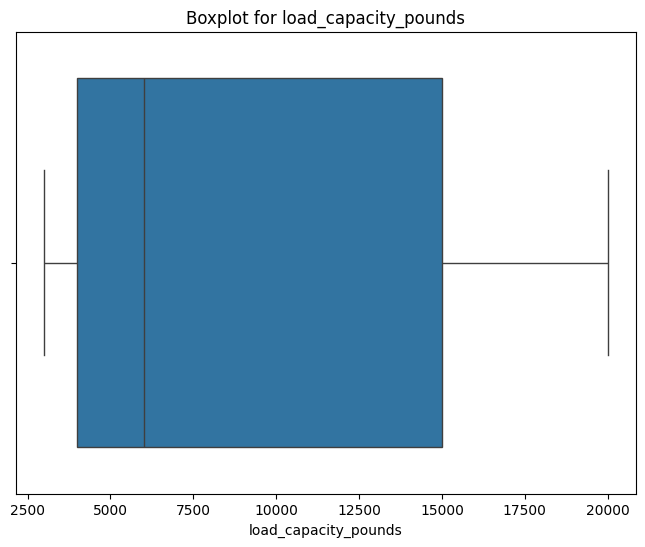

Number of outliers in 'load_capacity_pounds': 0
No outliers detected for 'load_capacity_pounds'.



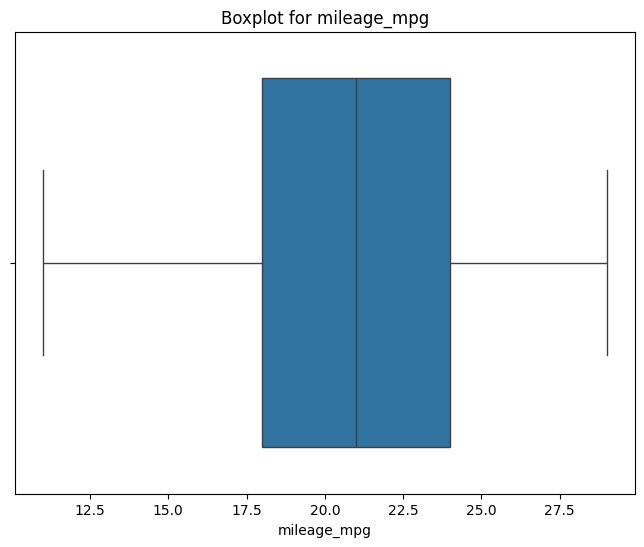

Number of outliers in 'mileage_mpg': 0
No outliers detected for 'mileage_mpg'.



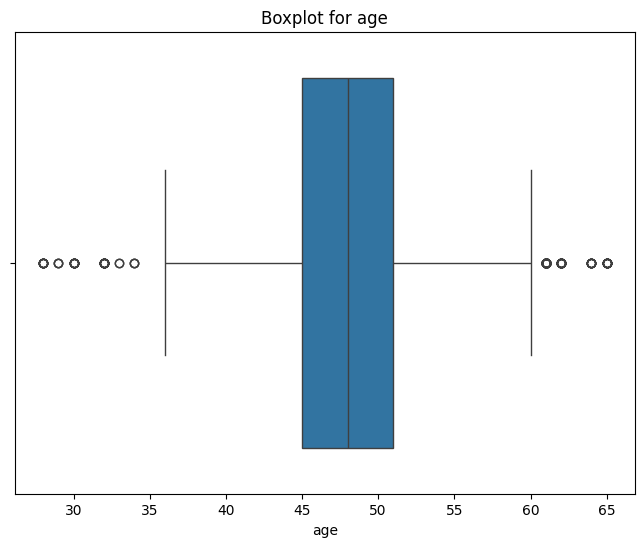

Number of outliers in 'age': 155
       age
188     61
236     29
243     62
248     34
343     62
...    ...
12136   61
12152   32
12331   61
12381   61
12547   61

[155 rows x 1 columns]


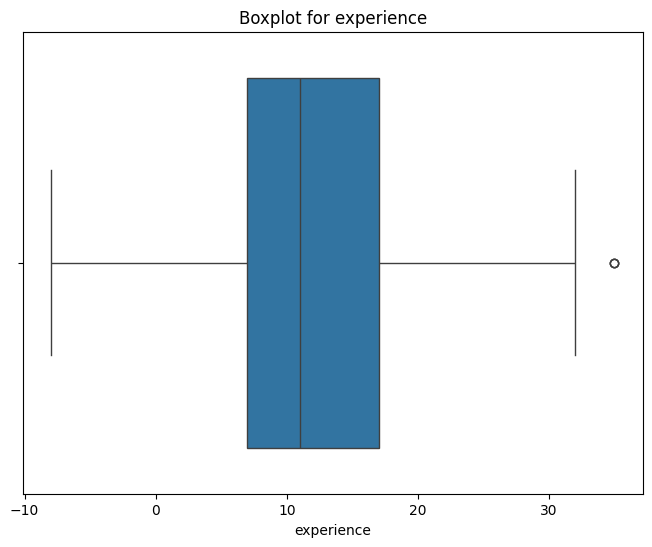

Number of outliers in 'experience': 3
      experience
69            35
4288          35
8505          35


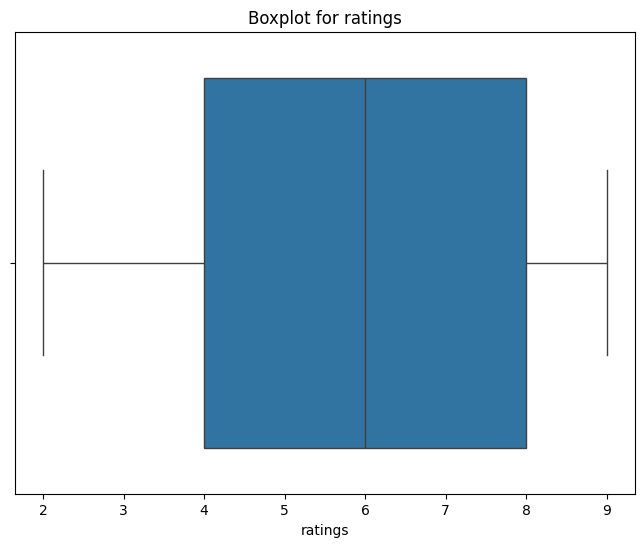

Number of outliers in 'ratings': 0
No outliers detected for 'ratings'.



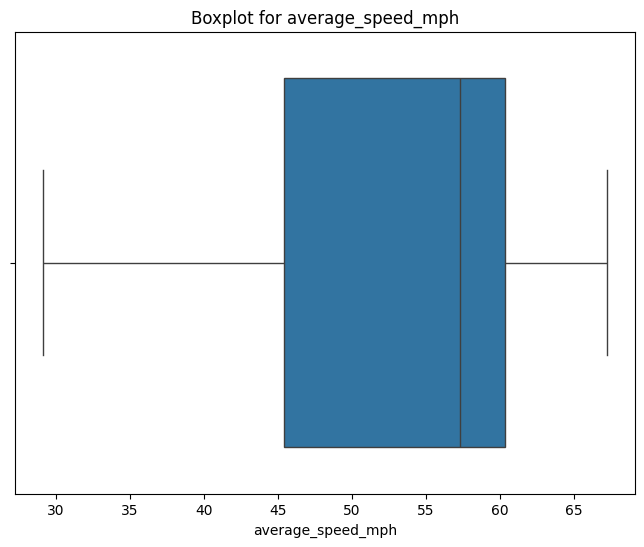

Number of outliers in 'average_speed_mph': 0
No outliers detected for 'average_speed_mph'.



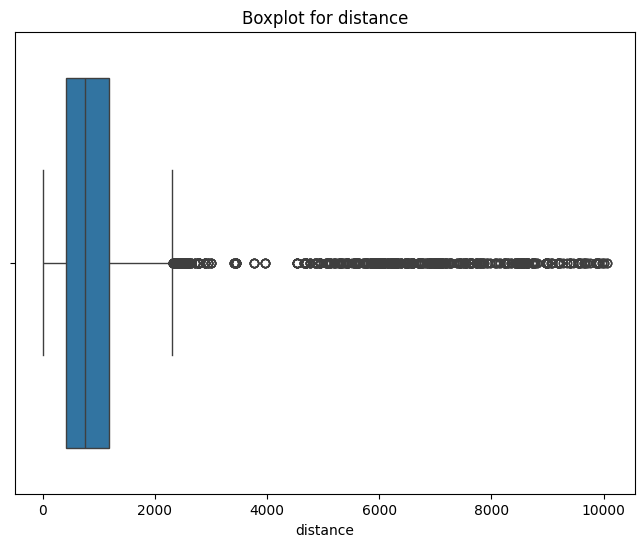

Number of outliers in 'distance': 1206
       distance
1       5306.97
2       5609.50
3       5615.56
4       6705.03
5       7874.83
...         ...
11961   4895.99
11966   2336.38
11969   4850.22
11971   2367.72
11973   2337.74

[1206 rows x 1 columns]


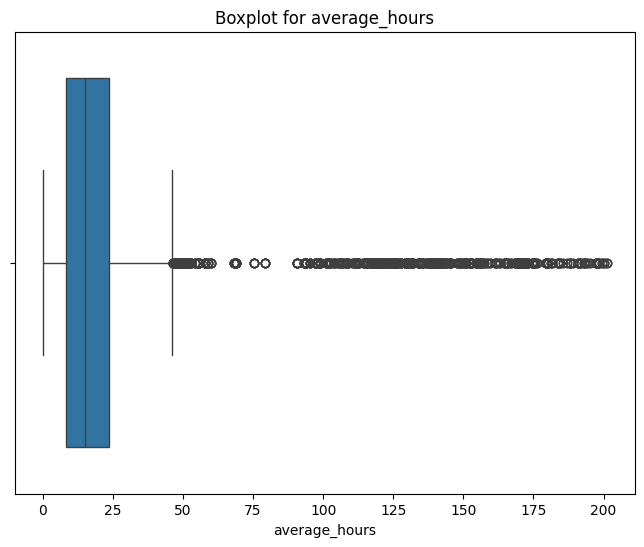

Number of outliers in 'average_hours': 1206
       average_hours
1             106.14
2             112.19
3             112.31
4             134.10
5             157.50
...              ...
11961          97.92
11966          46.73
11969          97.00
11971          47.35
11973          46.75

[1206 rows x 1 columns]


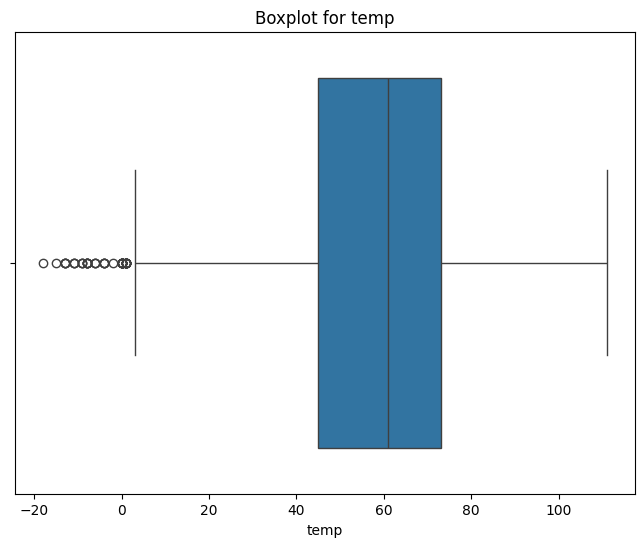

Number of outliers in 'temp': 51
       temp
332      -8
416       0
1158     -4
1499     -8
1878    -13
1899    -15
1965    -13
1985     -4
1986      0
1987     -4
2668      1
3208      1
3424    -13
3537      1
4219      0
4395    -11
4700     -8
4706     -6
5029    -11
5082      0
5084      0
5085     -6
5172     -9
5593      1
6746     -2
7345     -8
7365    -18
7451      1
7457      0
7688    -11
7707     -4
7708     -9
7722      0
7723     -8
7740      0
7741    -13
8034      1
8423      0
9647      0
10068    -6
10070     1
10236    -9
10237     1
10842     1
11201     1
11365    -8
11642     0
11800     1
11950     0
12075     0
12552     1


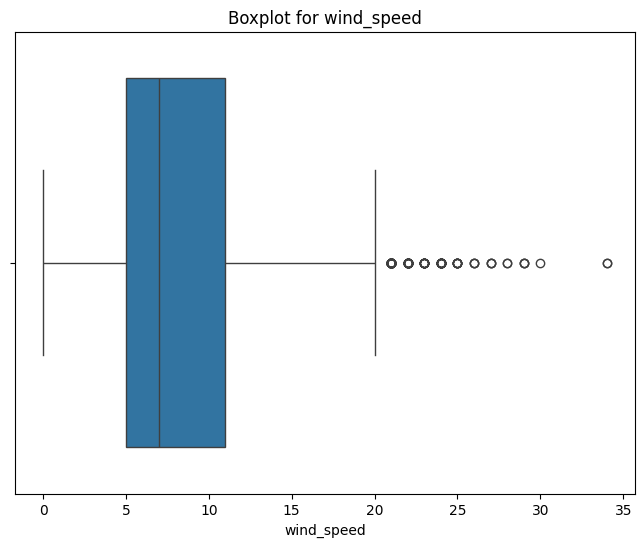

Number of outliers in 'wind_speed': 152
       wind_speed
50             29
61             21
84             21
99             22
101            22
...           ...
12157          24
12421          23
12424          21
12511          21
12581          21

[152 rows x 1 columns]


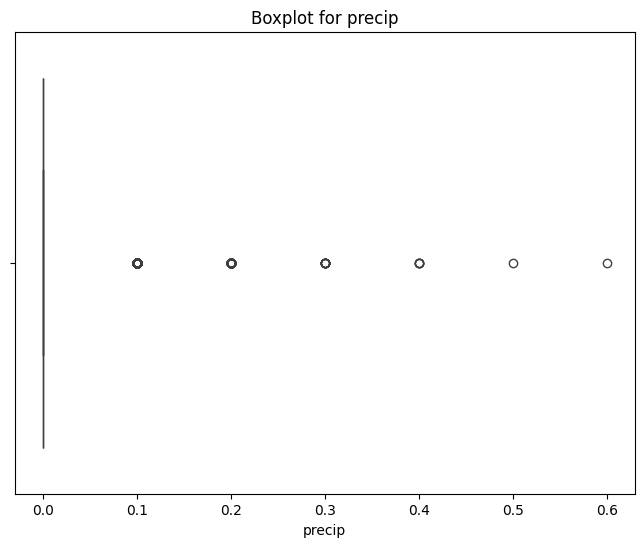

Number of outliers in 'precip': 589
       precip
18        0.1
23        0.1
31        0.1
32        0.2
118       0.1
...       ...
12402     0.1
12453     0.2
12464     0.1
12467     0.1
12511     0.2

[589 rows x 1 columns]


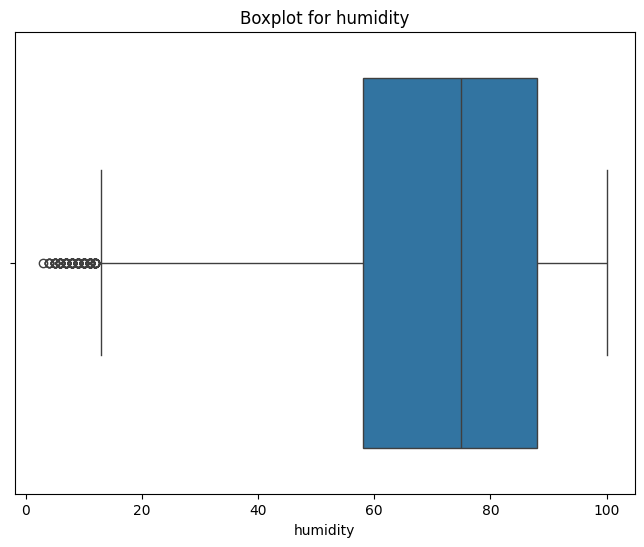

Number of outliers in 'humidity': 149
       humidity
37           11
43           10
418          10
444          10
603           7
...         ...
12229         5
12230         6
12231         3
12232         8
12234         9

[149 rows x 1 columns]


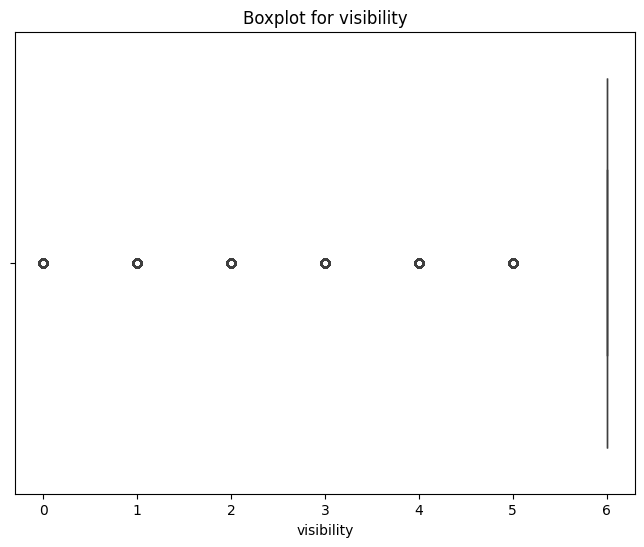

Number of outliers in 'visibility': 2467
       visibility
6               3
7               4
8               4
13              4
14              5
...           ...
12561           1
12575           2
12577           5
12604           4
12605           0

[2467 rows x 1 columns]


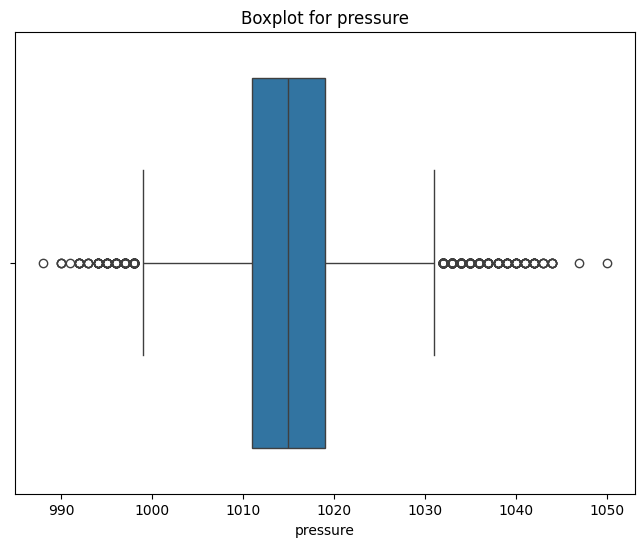

Number of outliers in 'pressure': 513
       pressure
46         1035
85         1032
88          997
199         997
208        1033
...         ...
12536      1036
12552      1036
12553      1047
12554      1033
12572      1034

[513 rows x 1 columns]


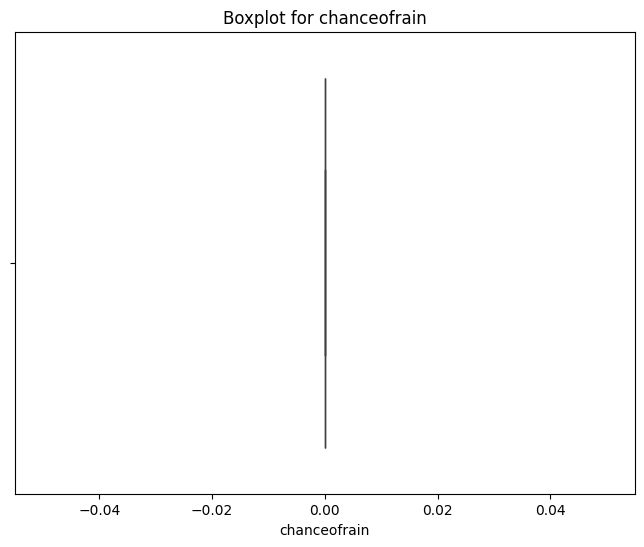

Number of outliers in 'chanceofrain': 0
No outliers detected for 'chanceofrain'.



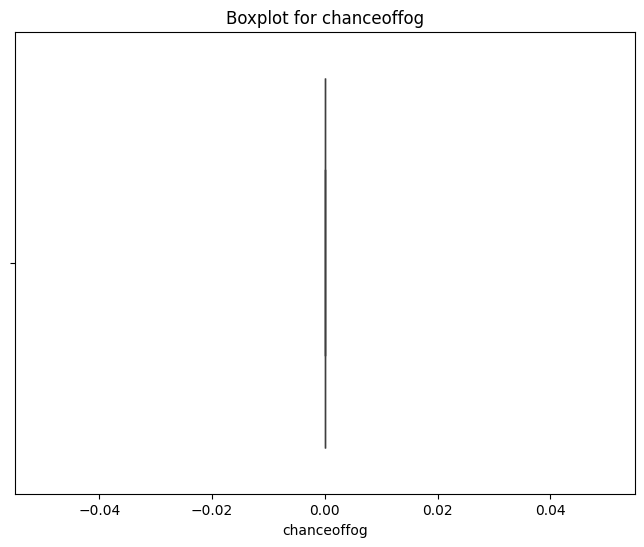

Number of outliers in 'chanceoffog': 0
No outliers detected for 'chanceoffog'.



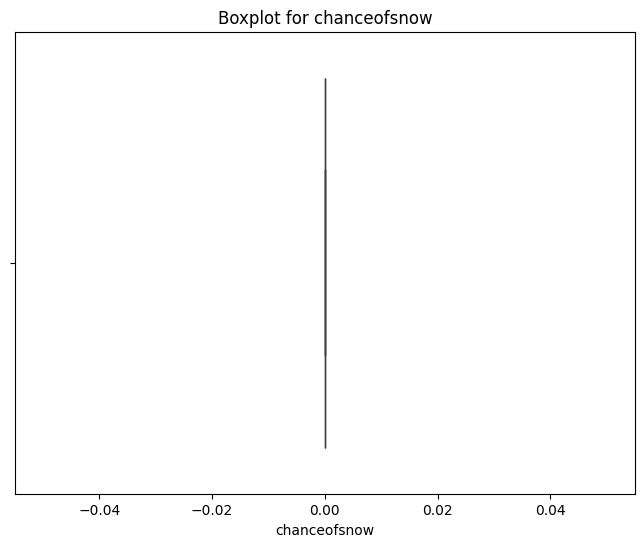

Number of outliers in 'chanceofsnow': 0
No outliers detected for 'chanceofsnow'.



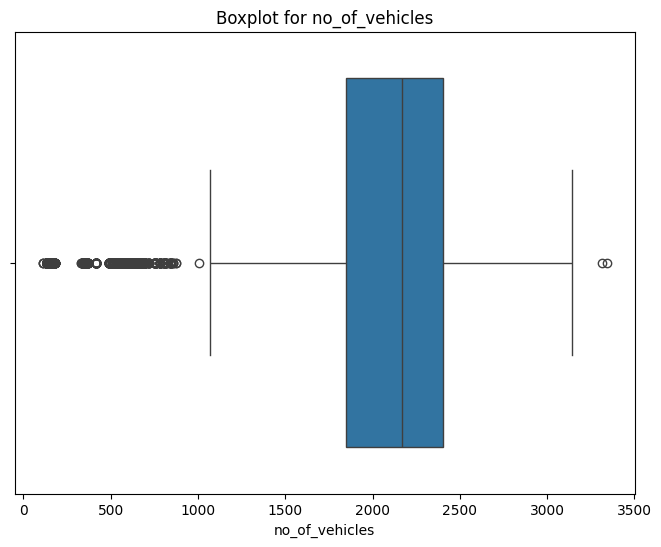

Number of outliers in 'no_of_vehicles': 2022
       no_of_vehicles
1               417.0
2               561.0
3               561.0
4               561.0
5               561.0
...               ...
12386           154.0
12490           135.0
12491           135.0
12492           135.0
12493           135.0

[2022 rows x 1 columns]


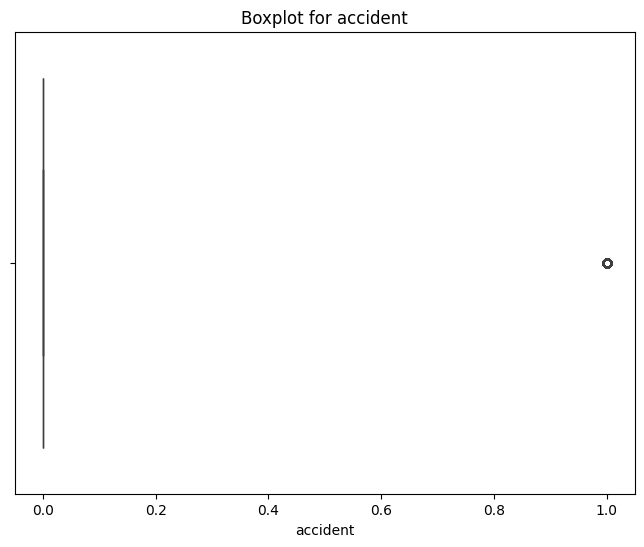

Number of outliers in 'accident': 596
       accident
51            1
61            1
65            1
161           1
183           1
...         ...
12519         1
12540         1
12544         1
12547         1
12572         1

[596 rows x 1 columns]


In [66]:
def plot_boxplots_and_identify_outliers(df, columns):
    # Loop through each specified column to plot boxplots and detect outliers
    for col in columns:
        # Check if the column exists in the DataFrame
        if col not in df.columns:
            print(f"Column '{col}' not found in the DataFrame.")
            continue

        # Plot the boxplot
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot for {col}')
        plt.show()

        # Calculate the IQR for outlier detection
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier condition
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # Print the number of outliers for the column
        print(f"Number of outliers in '{col}': {len(outliers)}")
        if len(outliers) > 0:
            print(outliers[[col]])  # Show the outliers
        else:
            print(f"No outliers detected for '{col}'.\n")

plot_boxplots_and_identify_outliers(df, df_filtered)


In [67]:
skewedData = ['humidity']
normalData = df_filtered.drop(columns=skewedData)

for col in normalData:
    mean = df[col].mean()  
    replace_outliers(df, col, mean, False)

for col in skewedData:
    mode = df[col].mode()[0]  #Gets the first mode value
    replace_outliers(df, col, mode, True)
    

Replaced outliers truck_age.
Replaced outliers load_capacity_pounds.
Replaced outliers mileage_mpg.
Replaced outliers age.
Replaced outliers experience.
Replaced outliers ratings.
Replaced outliers average_speed_mph.
Replaced outliers distance.
Replaced outliers average_hours.
Replaced outliers temp.
Replaced outliers wind_speed.
Replaced outliers precip.
Replaced outliers visibility.
Replaced outliers pressure.
Replaced outliers chanceofrain.
Replaced outliers chanceoffog.
Replaced outliers chanceofsnow.
Replaced outliers no_of_vehicles.
Replaced outliers accident.
Replaced outliers humidity.


C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[column].iloc[outliers] = replace_value
C:\Users\sriva\AppData\Local\Temp\ipykernel_24756\1654130995.py:9: SettingWithCopyWarn

KNN treatment

In [68]:
imputer = KNNImputer(n_neighbors=4)

transform_cols = ['load_capacity_pounds', 'city_wind_speed_x', 'city_humidity_x', 'no_of_vehicles']

df[transform_cols] = imputer.fit_transform(df[transform_cols])


In [69]:
null_summary2 =df.isnull().sum() #check again!
print(null_summary2[null_summary2 > 0])


Series([], dtype: int64)


In [70]:
df.to_csv('cleanedDf.csv', index=False)